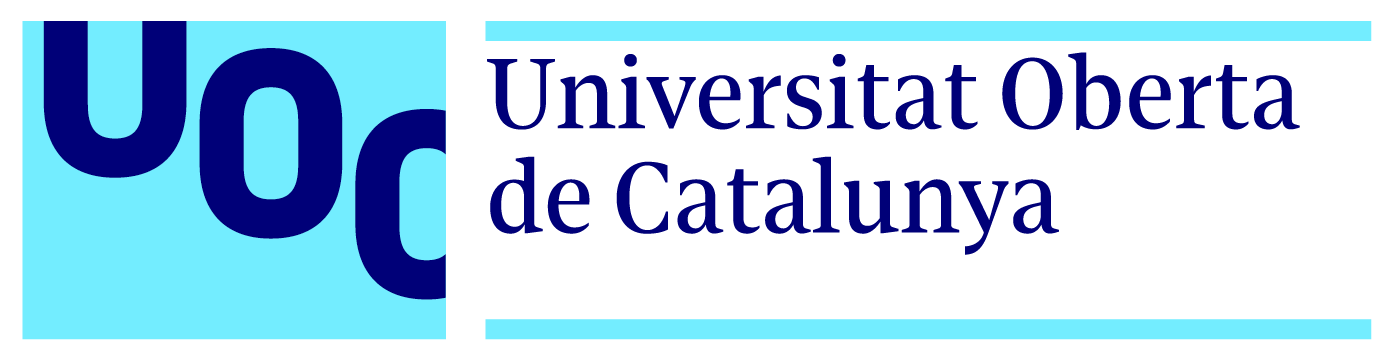

# PEC3 - Diseño e implementación del trabajo 

# Notebook 01 Analisis_Exploratorio

En este capítulo se detalla la parte principal del trabajo, que consiste en el tratamiento de los datos y la implementación de las técnicas para el posterior  desarrollo del modelo para que sea apto para la empresa y que nos permita
sacar las suficientes conclusiones.

El proceso que se lleva a cabo se ha guiado por las etapas propias de un proyecto de minería de datos.


Este notebook es el primer notebook  contienen las diferentes fases explicadas y justificadads de las decisiones tomadas en base a reporte de resultados. 
Este Notebook engloba toda la fase de trabajo previo a la ejecución del modelo.  


### Indice

* 1.Origen de los Datos
* 2. Exploración de los datos
* 3. Preparación de los Datos y Análisis estadístico
 * A Fichero Promo
 * B Fichero Previsiones
 * C Fichero Stock
 * D Fichero Ventas
* 4. Feature Engineering 
  * 1. Generación variable precio
  * 2. Generación variables día de la semana y semanada del mes
  * 3. Generación variable promoción
  * 4. Generación variable festivo
  * 5. Generación y estudio de nuevas variables temporales
  * 6. Generación variables dedicadas a ventas
  * 7. Feature Engineering Final
 * 5 Generación del fichero final
 

Salidas: MODELAR_FINAL.csv: Fichero que se usa de entrada para la realización del modelo en el ejercicio 1 y 2

### Librerias

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from datetime import timedelta 
import numpy as np
ruta ="/content/gdrive/MyDrive/TFM/3/"
#ruta = 'C:/Users/alfonso/Desktop/TFM/'
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelBinarizer
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram
from scipy.spatial.distance import squareform,pdist

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


 # 3.1 Origen de los datos 

Despues de analizar diferentes proyectos relevantes dentro del ámbito de investigación se toma objetivo diseñar y desarrollar e implementar una solución para una empresa del sector retail, determinando las claves de éxito y profundizar en la situación. Los datos de la empresa han sido anonimizados para la realización del proyecto.

Se han proporcionado los datos desde la empresa anonimizada, los datos se encuentran repartidos en  cuatro ficheros excel


* 01_Ventas.xlsx: Contiene las ventas de los productos de la empresa.

*	02_Promociones.xlsx: Contiene el periodo de promoción de los productos y la variación del precio del producto en cuestión.

* 03_Stock.xlsx: Contiene el volumen total de unidades del producto por día

*	04_PrevisionesEmpresa.xlsx: Unidades de producto que la empresa espera vender en un día determinado.



### 3.1.1 Carga de los datos

Una vez descritos los ficheros que componen los diferentes datos proporcionados por la empresa se cargan de manera individual

In [12]:
ventas=pd.read_excel(ruta+"01_Ventas.xlsx", sheet_name='Hoja1')


In [ ]:
promos=pd.read_excel(ruta+"02_Promos.xlsx", sheet_name='Hoja1')


In [ ]:
stock=pd.read_excel(ruta+"03_Stock.xlsx", sheet_name='Hoja1')


In [ ]:
previsiones=pd.read_excel(ruta+"04_PrevisionesEmpresa.xlsx", sheet_name='Hoja1')


# 3.2 Exploración de los datos

En esta fase se revisan por primera vez los datos que se han proporcionado desde la empresa del sector retail para ver patrones o reconocer algun tipo de distribución estadistica que pueda servir en las siguientes fases del desarrolllo. Además, se intenta extraer conclusiones para el futuro modelo.

### 3.2.1  Resumen de los datos. Análisis estadístico y de calidad de los datos inicial

Para esta fase inicial, en el analisis previo, buscando datos nulos, campos nulos duplicación de registros se va a ser uso de la herramienta Pandas Profiling[17]. Esta herramienta es capaz de crear reportes sencillos a partir de un conjunto de datos.

### Fichero Ventas

In [ ]:

profile_ventas = ProfileReport(ventas, title='Report ventas', html={'style':{'full_width':True}})

In [ ]:
profile_ventas.to_notebook_iframe()


Contiene 98411 registros, no tiene duplicados y todas las variables son de tipo númerico.
Por tanto, habrá que cambiar el formato de la columna fecha a formato Date. Habrá que reconstruir la serie temporal observando que si el día no aparece en el fichero para un producto, ese día las unidades vendidas de ese producto serán cero.




*  	Columna fecha: su registro minimo data de 29 junio de 2015 y su última fecha es de 23 de marzo de 2021. Se obtienen 1744 días diferentes mientras que la diferencia entre la fecha máxima y minima son más de 2000 días. Como se ha dicho en analisis anterior habrá que reconstruir la serie temporal observando que si el día no aparece en el fichero para un producto, ese día las unidades vendidas de ese producto serán cero
El analisis temporal es 5 años y 8 meses muy superior a los otros ficheros proporcionados tambíen habrá que procesar todas las variables de acuerdo a este análisis temporal.

*  Columna producto: Aunque es una columna de tipo entero, se trata de un identificador de producto que puede variar desde el valor 1 al 99. Indicar que pese a esta variación de productos solo hay 70 productos diferentes 
* 	Columna udsVenta: La distribución de unidades de venta se concentran hacia la izquierda, la mediana se encuentra en valor 525 y la media en el valor 828. El percentil 95 es el valor 2566 pero el valor máximo es 97044 habrá que tratar los outliers en fases posteriores





---



---



### Fichero Promos

In [ ]:
profile_promos = ProfileReport(promos, title='Report promoción', html={'style':{'full_width':True}})

In [ ]:
profile_promos.to_notebook_iframe()


Contiene 2672 registros, existen ocho columnas de las cuales dos son formato fecha, cinco son númericas y una categorica. No existen duplicados pero hay varias columnas con valores nulos. Por ejempo la columna tippromo tiene el 71% de valores a nulo. Habrá que reconstruir la columna creando una nueva serie historica de promociones con un booleano como otra para los diferentes precios ya que existen nulos

*	Columna iniciopromo: Columna tipo fecha, el valor minimo data de diciembre de 2015 y el valor maximo abril de 2021. No existen valores  inclocluentes ni nulos, indicar que hay 997 fechas diferentes de inicio de promoción.

* Columna finpromo: Columna tipo fecha donde el valor minimo es en enero de 2016 pero el valor maximo es en 2100-12-31. Existen 7 valores inconcluentes que habrá que tratar. Existen también 6 nulos en la columna que corresponden el 0.2% de los registros
*	Semanainicio: columna tipo entero que corresponde a la semana de inicio de la promoción los valores van de la semana 1 a la semana 53 no existen nulos ni valores inconcluentes
*	Semanafin: columna tipo entero que corresponde a la semana de fin de la promoción los valores van de la semana 1 a la semana 53, existen 6 valores nulos que se corresponden con los valores nulos de la columna finpromo. Esta columna esta correlacionada con semanainicio como se observa en la Figura 3.6.
*	Columna producto: Indicar que en este fichero solo existen 66 productos diferentes, es decir cuatro productos no han estado nunca en promoción. No existen nulos ni valores inconcluentes. El productos que más ha estado en promoción ha sido el producto 20. Indicar que como en esta columna se encuentra el precio del producto existe la posibilidad que en cuatro productos estime el valor del producto.
*	Columna preciotarifa: Columna númerica a la que corresponde el precio normal del producto. La media se encuentra en el valor 3.88 y el valor máximo en 6.2. Indicar que hay valores incoherentes como 16 registros con valor 0 y 37 valores nulos que representan el 1.4% del total. Tanto los registros nulos como inconcluentes habrá que tratarlos posteriormente.
*	Columna preciopromocion: Columna númerica a la que corresponde el precio del producto en promocióon. La media se encuentra en el valor 3.05 y el valor máximo en 5.03. La disminución del precio medio en época de promoción se situa alrededor del 21%. Indicar que hay valores incoherentes como 15 registros con valor 0 y 96 valores nulos que representan el 3.6% del total de registros. Tanto los registros nulos como incoherentes habrá que tratarlos posteriormente.
o	Columna tipopromo: Una columna categórica el 70,7% de los registros estan a nulo y la distribución de los valores nulos se



---



---



### Fichero Stock

In [ ]:

profile_stock = ProfileReport(stock, title='Report stock', html={'style':{'full_width':True}})

In [ ]:
profile_stock.to_notebook_iframe()


Contiene 29836 registros, existen tres columnas de las cuales una es formato date y las otras dos son formato númerico. No existen nulos ni duplicados. En este caso habrá que poner enfasis en los días que no existe stock para un producto, habrá que realizar algún tipo de procesamiento para los valores que no aparecen en la serie temporal

*	Columna fecha: su registro minimo data de 05 junio de 2019 y su última fecha es de 24 de marzo de 2021. Se observan 565 días diferentes en el analisis estadistico mientras que la diferencia entre la fecha máxima y minima son 658 días. Como se ha indicado en apartados anteriores anterior habrá que poner enfasis en los días que no existe stock para un producto y procesarlo de manera correcta.
Los datos correspondiente a información de stock es de 1 año y 9 meses inferior al periodo de ventas de productos, una vez que todas las variables se contengan en el mismo conjunto de datos se tendrá que analizar la correlación entre las unidades de stock y las unidades de venta en el mismo instante temporal.
*	Columna producto: columna correspondiente al identificador de producto que puede variar desde el valor 1 al 99. Indicar que solo hay 67 productos de los que se tiene stock
*	Columna udsStock: La distribución de unidades de stock se concentran hacia la izquierda,es decir con una asimetria a la derecha. La mediana se encuentra en valor 494 y la media en el valor 827. El percentil 95 es el valor 2573 pero el valor máximo es 37299. Habrá que tratar los outliers en fases posteriores y comparando los valores con las unidades de venta en mismos instantes temporales.




---



---



### Fichero Previsiones

In [ ]:

profile_previsiones = ProfileReport(previsiones, title='Report previsiones', html={'style':{'full_width':True}})

In [ ]:
profile_previsiones.to_notebook_iframe()


In [13]:
ventas['fecha'] = pd.to_datetime(ventas['fecha'], format='%Y%m%d')


Contiene 30028 registros existen tres columnas de las cuales una es formato date y las otras dos son formato númerico. Aunque no hay nulos ni duplicados existen periodos donde no hay prediciones de la propia empresa, habrá que realizar algún tipo de tecnica de procesamiento para completar la serie temporal.

*	Columna fecha: su registro minimo data de 1 de enero de 2019 y su última fecha es de 23 de febrero de 2021. Se observan 534 días diferentes en el analisis estadistico mientras que se observa un periodo sin datos como se observa en la Figura 3.7. Como se ha indicado en apartados anteriores anterior habrá que poner enfasis en los días que no existe predicción de los productos.
*	Columna producto: columna correspondiente al identificador de producto que puede variar desde el valor 1 al 99. Indicar que hay 70 productos de los que se tiene previsión.
*	Columna udsPrevisionEmpresa: La distribución de unidades de stock se concentran hacia la izquierda,es decir con una asimetria a la derecha. En este caso el valor de las unidades vendidas es mayor que las unidades de stock y las ventas ya que la media se situa en el valor 4564 y la mediana en el valor 2417 mientras que el percentil 95 se encuentra en 15676. Es un incremento muy grande respecto a otros registros de unidades de stock y de venta.






---



---



---



# 3.3.  Preparación de los datos

##  A Preparación de los datos - Fichero Promo

Se seleccionan las columnas necesarias para realizar el analisis

In [ ]:
promos=promos[['iniciopromo','finpromo','Producto','preciotarifa','preciopromocion']]
promos = promos.reset_index(drop = True)

### 3.3.0 Eliminación de nulos columna finpromo

Se comprueba si existen registros nulos en la 
columna finpromo, en caso afirmativo, se desconocerá el fin de la promoción. Por ello se procede a sustituir el valor nulo por fecha inicio para indicar que ese día si existió una promoción

In [ ]:
promos.isna().sum()

iniciopromo         0
finpromo            6
Producto            0
preciotarifa       37
preciopromocion    96
dtype: int64

In [ ]:
promos.loc[promos["finpromo"].isna(),"finpromo"]=promos["iniciopromo"]

Se comprueba que no hay registros a valor nulo en esta columna

In [ ]:
promos.loc[promos["finpromo"].isna()]

Empty DataFrame
Columns: [iniciopromo, finpromo, Producto, preciotarifa, preciopromocion]
Index: []

### 3.3.1 Eliminación de registros incoherente

Se comprueba si en la columna finpromo existen registros que no tienen sentido como promociones mayores a Junio de 2021. En caso afirmativo, se sustituye la fecha finpromo por la columna iniciopromo, como en el caso anterior

In [ ]:
promos.loc[promos["finpromo"]>"2021-06-01"]

iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
797   2020-01-16 2099-01-16        24       4.29300              NaN
835   2019-12-24 2100-12-31        69       4.28004              NaN
1273  2019-02-28 2025-02-28        40       4.37400              NaN
1274  2019-02-28 2025-02-28        69       4.39830              NaN
1275  2019-02-27 2025-02-28        40       4.37400              NaN
1276  2019-02-27 2025-02-28        69       4.39830              NaN
1586  2018-07-11 2100-12-31        96       4.81950           3.9571

Se comprueba si hay algun registro incoherente

In [ ]:
promos.loc[promos["finpromo"]>"2021-06-01","finpromo"]=promos["iniciopromo"]

### 3.3.1 Eliminación de duplicados

Se comprueba si existen duplicados. en el report inicial se observa que no existen duplicados para todos los registros pero seleccionando columnas "clave" se eliminan los registros duplicados que puedan existir

In [ ]:
promos.duplicated().sum()

11

In [ ]:

promos = promos.drop_duplicates()
promos = promos.reset_index(drop = True)

In [ ]:
promos[['iniciopromo','finpromo','Producto']].duplicated().sum()

120

Aún eliminando registros duplicados, se siguen observando duplicados por campos clave, como por ejemplo, en fila 22 y 23, se observa que para la misma fecha y mismo producto tienen registros de precios diferentes. Al no conocer que registro es el correcto, se procede a realizar la media entre los registros duplicados 

In [ ]:
promos.iloc[21:24,:]


iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
21  2021-03-24 2021-04-07        64       3.68145           2.8651
22  2021-03-22 2021-04-05        20       3.52350           2.5900
23  2021-03-22 2021-04-05        20       3.92850           2.5620

In [ ]:
promos=promos.groupby(['iniciopromo','finpromo','Producto'], as_index=False)[['preciotarifa','preciopromocion']].mean()
  

Comprobación de los registros anteriores y su transformación

In [ ]:
promos.loc[(promos['iniciopromo']=="2021-03-22")&(promos['finpromo']=="2021-04-05")&(promos['Producto']==20)]

iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
2516  2021-03-22 2021-04-05        20         3.726            2.576

In [ ]:
promos=promos.sort_values(by=["Producto","iniciopromo"])

### 3.3.2 Correción de fechas

Se comprueba con criterio si las fechas de inicio promo tienen sentido, es decir, si la fecha finpromo ocurre en una fecha igual o posterior a iniciopromo. En el caso que haya registros irrazonables se prodece a sustituir los datos entre las dos columnas 

In [ ]:
promos.loc[promos["finpromo"]<promos["iniciopromo"]]

iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
1762  2019-12-13 2019-01-26        20        3.3615              NaN
1627  2019-08-31 2019-08-06        31        4.3740            3.325
1159  2018-09-21 2018-08-29        42        4.3740            3.465
2490  2021-03-08 2021-02-14        61        3.5235            2.835
1139  2018-09-07 2018-08-15        62        4.2120            3.276

In [ ]:
promos["iniciopromo2"]= np.where((promos["finpromo"]<promos["iniciopromo"]), promos["finpromo"], promos["iniciopromo"])
promos["finpromo2"]=  np.where((promos["finpromo"]<promos["iniciopromo"]), promos["iniciopromo"], promos["finpromo"])

In [ ]:
promos.loc[promos["finpromo"]<promos["iniciopromo"]]

iniciopromo   finpromo  Producto  ...  preciopromocion  iniciopromo2  finpromo2
1762  2019-12-13 2019-01-26        20  ...              NaN    2019-01-26 2019-12-13
1627  2019-08-31 2019-08-06        31  ...            3.325    2019-08-06 2019-08-31
1159  2018-09-21 2018-08-29        42  ...            3.465    2018-08-29 2018-09-21
2490  2021-03-08 2021-02-14        61  ...            2.835    2021-02-14 2021-03-08
1139  2018-09-07 2018-08-15        62  ...            3.276    2018-08-15 2018-09-07

[5 rows x 7 columns]

In [ ]:
promos["finpromo"]=promos["finpromo2"]
promos["iniciopromo"]=promos["iniciopromo2"]

del promos['finpromo2']
del promos['iniciopromo2']


In [ ]:
promos = promos.reset_index()
del promos['index']

Nueva comprobación de fechas razonables

In [ ]:
promos.loc[promos["finpromo"]<promos["iniciopromo"]]

Empty DataFrame
Columns: [iniciopromo, finpromo, Producto, preciotarifa, preciopromocion]
Index: []

### 3.3.3 Promociones duplicadas

En este caso despues de ordenar las columnas por fecha de inicio de promoción se estudia que para un producto en concreto existen varias promociones para los mismos periodos con distintos precios.

En este caso prevalecen las promociones que se alargan en el tiempo frente a las que duran menos, estas se eliminan del fichero

In [ ]:
promos.loc[promos[["iniciopromo","Producto"]].duplicated(keep=False)]

iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
51    2020-06-02 2020-06-02         1       3.79323           3.2781
52    2020-06-02 2020-06-04         1       3.51945           3.0415
194   2016-03-11 2016-03-22        10       3.15900           2.7300
195   2016-03-11 2016-03-23        10       3.15900           2.7300
196   2016-03-11 2016-03-24        10       3.15900           2.7300
...          ...        ...       ...           ...              ...
2527  2020-06-12 2020-06-15        98       3.30399           2.6705
2528  2020-06-12 2020-06-26        98       3.11850           2.2610
2538  2021-03-29 2021-03-30        98       3.30399           2.5697
2539  2021-03-29 2021-03-31        98       3.30399           2.5697
2540  2021-03-29 2021-04-01        98       3.30399           2.5697

[211 rows x 5 columns]

In [ ]:
promos.drop_duplicates(subset=["iniciopromo","Producto"] ,keep="last",inplace=True)

In [ ]:
promos = promos.reset_index()
del promos['index']

### 3.3.4 Correción de preciotarifa y preciopromocion

Las columnas preciotarifa y preciopromocion necesitan cierto tratamiento para que posteriormente sean utiles en el analisis de datos, se destaca:

1.   Eliminar los 0s en el precio: Un producto no puede valer 0€ se sustituye por nulos para despues tratarlos.
2.   Corregir precios: Existen registros incoherentes entre las dos columnas de precio, siendo el preciopromocion mayor que el preciotarifa. Para corregir este error se intercambian los datos de los precios para que el registro tenga sentido.
3.   Remplazar nulos. Para reemplazar los nulos se sigue la estrategia de, Cuando su valor es nulo, se  completa con el precio anterior temporalmente más cercano para cada artículo. 



**Eliminación de precio a 0€**

In [ ]:
promos.loc[promos["preciotarifa"]==0].count()

iniciopromo        13
finpromo           13
Producto           13
preciotarifa       13
preciopromocion     8
dtype: int64

In [ ]:
promos["preciotarifa"].replace(0.0, np.nan, inplace=True)
promos["preciopromocion"].replace(0.0, np.nan, inplace=True)


In [ ]:
promos.isna().sum()

iniciopromo          0
finpromo             0
Producto             0
preciotarifa        46
preciopromocion    101
dtype: int64



---




**Correción de precios incoherentes**

In [ ]:
promos.loc[promos["preciotarifa"]<promos["preciopromocion"]]

iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
958   2016-04-30 2016-05-03        26        3.5235            3.577
1259  2021-01-13 2021-01-25        37        1.6605            2.870
1264  2016-04-30 2016-05-03        38        3.5235            3.948

In [ ]:
promos["preciotarifa2"]= np.where((promos["preciotarifa"]<promos["preciopromocion"]), promos["preciopromocion"], promos["preciotarifa"])
promos["preciopromocion2"]=  np.where((promos["preciopromocion"]>promos["preciotarifa"]), promos["preciotarifa"], promos["preciopromocion"])

In [ ]:
promos.loc[promos["preciotarifa"]<promos["preciopromocion"]]

iniciopromo   finpromo  ...  preciotarifa2  preciopromocion2
958   2016-04-30 2016-05-03  ...          3.577            3.5235
1259  2021-01-13 2021-01-25  ...          2.870            1.6605
1264  2016-04-30 2016-05-03  ...          3.948            3.5235

[3 rows x 7 columns]

In [ ]:
promos["preciopromocion"]=promos["preciopromocion2"]
promos["preciotarifa"]=promos["preciotarifa2"]

del promos['preciopromocion2']
del promos['preciotarifa2']


In [ ]:
promos.loc[promos["preciotarifa"]<promos["preciopromocion"]]

Empty DataFrame
Columns: [iniciopromo, finpromo, Producto, preciotarifa, preciopromocion]
Index: []

In [ ]:
promos.loc[promos["iniciopromo"]<"2015-01-01"]

Empty DataFrame
Columns: [iniciopromo, finpromo, Producto, preciotarifa, preciopromocion]
Index: []

In [ ]:
promos.loc[promos["finpromo"]>"2021-06-01"]

Empty DataFrame
Columns: [iniciopromo, finpromo, Producto, preciotarifa, preciopromocion]
Index: []



---




**Tratamiento de valores nulos**

In [ ]:
# Cuando su valor es nulo, ha de ser completado con el precio anterior temporalmente más cercano para cada artículo.

In [ ]:
promos1=promos

In [ ]:
promos1['last_price'] = promos1[['Producto','iniciopromo','preciotarifa']].sort_values(by=['Producto','iniciopromo']).groupby(['Producto'], as_index=False).fillna(method = 'ffill')['preciotarifa']

In [ ]:
promos1.loc[promos["preciotarifa"].isna()]

iniciopromo   finpromo  ...  preciopromocion  last_price
0     2016-02-12 2016-02-12  ...              NaN         NaN
1     2016-02-19 2016-02-19  ...              NaN         NaN
2     2016-03-24 2016-03-24  ...              NaN         NaN
3     2016-04-23 2016-04-26  ...              NaN         NaN
4     2016-07-15 2016-07-15  ...              NaN         NaN
5     2016-11-04 2016-11-04  ...              NaN         NaN
6     2016-11-11 2016-11-11  ...              NaN         NaN
54    2016-04-16 2016-04-16  ...              NaN         NaN
83    2016-04-26 2016-04-26  ...              NaN         NaN
84    2016-05-18 2016-05-20  ...              NaN         NaN
85    2016-09-24 2016-09-27  ...              NaN         NaN
117   2016-09-17 2016-09-20  ...              NaN         NaN
118   2016-11-25 2016-11-25  ...              NaN         NaN
146   2016-02-19 2016-02-19  ...              NaN         NaN
147   2016-02-24 2016-02-26  ...              NaN         NaN
148   2016-04-20 2016-04-22  ...              NaN         NaN
149   2016-06-29 2016-07-01  ...              NaN         NaN
150   2016-08-10 2016-08-12  ...              NaN         NaN
151   2016-10-05 2016-10-07  ...              NaN         NaN
196   2016-06-07 2016-06-17  ...              NaN     3.15900
197   2016-06-08 2016-06-20  ...              NaN     3.15900
198   2016-07-08 2016-07-22  ...              NaN     3.15900
248   2016-10-14 2016-10-14  ...              NaN         NaN
249   2016-10-17 2016-10-17  ...              NaN         NaN
310   2016-04-25 2016-05-10  ...              NaN         NaN
394   2016-04-15 2016-04-15  ...              NaN         NaN
395   2016-04-16 2016-04-19  ...              NaN         NaN
396   2016-06-22 2016-06-24  ...              NaN         NaN
397   2016-09-07 2016-09-09  ...              NaN         NaN
398   2016-11-16 2016-11-18  ...              NaN         NaN
411   2016-09-26 2016-10-03  ...           3.0485     5.69349
497   2018-04-03 2018-04-03  ...              NaN     4.42260
535   2018-04-10 2018-04-10  ...              NaN     4.04838
607   2018-03-16 2018-03-31  ...              NaN     3.19950
902   2019-01-15 2019-01-28  ...              NaN     5.39460
1233  2016-10-14 2016-10-20  ...              NaN     5.87250
1243  2018-02-27 2018-03-12  ...              NaN     3.28050
1246  2018-04-26 2018-04-27  ...              NaN     3.28050
1324  2018-04-01 2018-04-01  ...              NaN     4.37400
1385  2018-04-03 2018-04-03  ...              NaN     4.42260
1516  2019-04-20 2019-04-29  ...           3.0030     3.70899
1517  2019-04-22 2019-04-29  ...           3.0030     3.70899
1928  2018-04-01 2018-04-01  ...              NaN         NaN
2006  2018-01-31 2018-02-16  ...           0.8036     1.09350
2235  2016-08-01 2016-08-07  ...           2.7650     3.76650
2281  2016-08-01 2016-08-07  ...           3.7450     4.57650

[46 rows x 6 columns]

In [ ]:
promos1['preciotarifa'] = promos1['last_price']
promos1 = promos1.drop(['last_price'], axis = 1)


In [ ]:
promos1.isna().sum()

iniciopromo          0
finpromo             0
Producto             0
preciotarifa        28
preciopromocion    101
dtype: int64

In [ ]:
promos1['last_price'] = promos1[['Producto','preciopromocion','preciotarifa']].sort_values(by=['Producto','preciopromocion']).groupby(['Producto'], as_index=False).fillna(method = 'ffill')['preciopromocion']

In [ ]:
promos1['preciopromocion'] = promos1['last_price']
promos1 = promos1.drop(['last_price'], axis = 1)

In [ ]:
promos1.isna().sum()

iniciopromo         0
finpromo            0
Producto            0
preciotarifa       28
preciopromocion     0
dtype: int64

In [ ]:
promos2=promos1

In [ ]:
promos2['preciotarifa'].fillna(method='pad', inplace=True)


In [ ]:
promos2.loc[promos["preciotarifa"]<promos["preciopromocion"]]

Empty DataFrame
Columns: [iniciopromo, finpromo, Producto, preciotarifa, preciopromocion]
Index: []

In [ ]:
promos2.isna().sum()

iniciopromo        0
finpromo           0
Producto           0
preciotarifa       7
preciopromocion    0
dtype: int64



Se observa que hay registros, debido a que no tienen un precio anterior, que siguen teniendo el valor nulo del precio.*En caso que no tenga ningun producto anterior se sustituye por el posterior de manera individual*

In [ ]:
promos2.head(10)

iniciopromo   finpromo  Producto  preciotarifa  preciopromocion
0  2016-02-12 2016-02-12         1           NaN            3.304
1  2016-02-19 2016-02-19         1           NaN            3.304
2  2016-03-24 2016-03-24         1           NaN            3.304
3  2016-04-23 2016-04-26         1           NaN            3.304
4  2016-07-15 2016-07-15         1           NaN            3.304
5  2016-11-04 2016-11-04         1           NaN            3.304
6  2016-11-11 2016-11-11         1           NaN            3.304
7  2017-01-14 2017-01-17         1        3.8232            3.304
8  2017-01-20 2017-01-20         1        3.8232            3.304
9  2017-03-02 2017-03-03         1        3.8232            3.304

In [ ]:
promos2.replace(np.nan, 3.8232, inplace=True)


In [ ]:
promos2.isna().sum()

iniciopromo        0
finpromo           0
Producto           0
preciotarifa       0
preciopromocion    0
dtype: int64

 Se realiza un análisis de los datos que siguen siendo nulos



### 3.3.5 Generación de fechas para la construccion del dataframe

Para poder hacer uso del fichero de promociones se genera la serie temporal a nivel diario de todas las promociones por producto. Esto da a lugar a otras problematicas que se solucionan posteriormente

In [ ]:
df=promos2[["iniciopromo","finpromo","Producto"]]

In [ ]:
fechas= df.apply(lambda s: pd.date_range(s['iniciopromo'], s['finpromo'], freq='D').tolist(), 1)
df['fecha']=fechas
df = df.explode('fecha')

In [ ]:
Cruce_1=pd.merge(df, promos2, on=['iniciopromo','finpromo','Producto'], how='left')

In [ ]:
Cruce_1.iloc[14:17,:]


iniciopromo   finpromo  Producto      fecha  preciotarifa  preciopromocion
14  2017-01-20 2017-01-20         1 2017-01-20        3.8232            3.304
15  2017-03-02 2017-03-03         1 2017-03-02        3.8232            3.304
16  2017-03-02 2017-03-03         1 2017-03-03        3.8232            3.304

In [ ]:
Cruce_1.isna().sum()

iniciopromo        0
finpromo           0
Producto           0
fecha              0
preciotarifa       0
preciopromocion    0
dtype: int64

In [ ]:
Cruce_1.duplicated().sum()


0

### 3.3.6 Eliminación de duplicados con promociones que engloban a otras promociones

Al analizar la serie temporal se observa que para la misma fecha existen mismas promociones para los mismos productos. En primer caso se observa en la muestra inferior que tienen la misma terminación. En este caso se  selecciona el registro con la fecha más antigua ya que engloba más tiempo.

In [ ]:
Cruce_1.sort_values(by=["fecha","finpromo","Producto"],inplace=True)

In [ ]:
Cruce_1.loc[Cruce_1[["fecha","finpromo","Producto"]].duplicated(keep=False)]


iniciopromo   finpromo  ...  preciotarifa preciopromocion
13984  2016-02-17 2016-02-26  ...       4.53600          3.6400
13993  2016-02-18 2016-02-26  ...       4.53600          3.6400
13985  2016-02-17 2016-02-26  ...       4.53600          3.6400
13994  2016-02-18 2016-02-26  ...       4.53600          3.6400
13986  2016-02-17 2016-02-26  ...       4.53600          3.6400
...           ...        ...  ...           ...             ...
4603   2021-04-26 2021-05-03  ...       4.13829          3.4118
4596   2021-04-24 2021-05-03  ...       4.13829          3.4118
4604   2021-04-26 2021-05-03  ...       4.13829          3.4118
4597   2021-04-24 2021-05-03  ...       4.13829          3.4118
4605   2021-04-26 2021-05-03  ...       4.13829          3.4118

[2076 rows x 6 columns]

In [ ]:
Cruce_1.drop_duplicates(subset=["fecha","finpromo","Producto"] ,keep="first",inplace=True)

In [ ]:
promos = promos.reset_index()
del promos['index']

In [ ]:
Cruce_1.shape

(24411, 6)

Se sigue estudiando los duplicados en el fichero eliminando las columnas iniciopromo y finpromo para obtener las columnas más relevantes. Al realizar esta segregación se observan que para los campos clave como son producto y fecha siguen existiendo registros duplicados por preciotarifa o preciopromocion. Para eliminar estos últimos registros duplicados se realiza un groupBy por las columnas claves obteniendo la media de los registros de precio ya que en caso de ser del mismo valor la columna precio este no variaría.

In [ ]:
Cruce_1=Cruce_1[["fecha","Producto","preciotarifa","preciopromocion"]]

In [ ]:
Cruce_1.drop_duplicates(inplace=True,ignore_index=True)

In [ ]:
Cruce_1[["fecha","Producto"]].duplicated().sum()

3082

In [ ]:
Cruce_1=Cruce_1.groupby(['fecha','Producto'], as_index=False)[['preciotarifa','preciopromocion']].mean()


In [ ]:
Cruce_1.head()

fecha  Producto  preciotarifa  preciopromocion
0 2015-12-09        88        3.3615            2.695
1 2015-12-10        88        3.3615            2.695
2 2015-12-11        88        3.3615            2.695
3 2015-12-12        88        3.3615            2.695
4 2015-12-13        88        3.3615            2.695

In [ ]:
Cruce_1.loc[Cruce_1[["fecha","Producto"]].duplicated(keep=False)]

Empty DataFrame
Columns: [fecha, Producto, preciotarifa, preciopromocion]
Index: []

### 3.3.7 Creación de la columna promoción
Para finalizar se crea la columna promoción que posteriormente se estudiará como si fuera un booleano

In [ ]:
Cruce_1["promocion"]=1

In [ ]:
Cruce_1.head()


fecha  Producto  preciotarifa  preciopromocion  promocion
0 2015-12-09        88        3.3615            2.695          1
1 2015-12-10        88        3.3615            2.695          1
2 2015-12-11        88        3.3615            2.695          1
3 2015-12-12        88        3.3615            2.695          1
4 2015-12-13        88        3.3615            2.695          1

In [ ]:
Cruce_1.to_csv("/content/gdrive/MyDrive/TFM/3/Promociones_Filtrado.csv", index = False)




---



---



---



## B  Preparación de los datos - Fichero Previsiones

### 3.3.0 Generación de la serie temporal del fichero

In [ ]:
previsiones[["fecha","Producto"]].duplicated().sum()

0

In [ ]:
previsiones=previsiones.sort_values(by=["Producto","fecha"])

In [ ]:
prueba_conteos=previsiones[['fecha']].groupby(['fecha']).size()

Se observa que existe un mes de decalaje entre Enero 2019 y 2020 y se decide eliminar las dos primeras fechas y comenzar desde el 26 de febrero de 2019

In [ ]:
prueba_conteos.head(20)

fecha
2019-01-30    63
2019-01-31    65
2019-02-27    67
2019-02-28    65
2019-03-01    69
2019-03-02    27
2019-03-03     2
2019-03-04    67
2019-03-05    67
2019-03-06    67
2019-03-07    64
2019-03-08    69
2019-03-09    26
2019-03-10     2
2019-03-11    67
2019-03-12    67
2019-03-13    68
2019-03-14    65
2019-03-15    69
2019-03-16    26
dtype: int64

In [ ]:
previsiones=previsiones.loc[previsiones["fecha"]>"2019-02-26"]

Se seleccionan la fecha máxima y mínima por producto

In [ ]:
fecha_min=previsiones.groupby(['Producto'], as_index=False)[['fecha']].min()
fecha_max=previsiones.groupby(['Producto'], as_index=False)[['fecha']].max()


In [ ]:
fecha_min=fecha_min.rename(columns = { 'fecha':'fecha_min'})

In [ ]:
fecha_max=fecha_max.rename(columns = { 'fecha':'fecha_max'})

In [ ]:
fecha_max.shape

(70, 2)

In [ ]:
Cruce_ini=pd.merge(fecha_min, fecha_max, on=["Producto"], how='inner',left_index=False, right_index=False)

In [ ]:
Cruce_ini.head()

Producto  fecha_min  fecha_max
0         1 2019-02-27 2020-08-22
1         2 2019-02-27 2021-02-23
2         3 2019-02-27 2021-02-23
3         4 2019-02-27 2021-02-23
4         5 2019-02-27 2021-02-23

In [ ]:
fechas= Cruce_ini.apply(lambda s: pd.date_range(s['fecha_min'], s['fecha_max'], freq='D').tolist(), 1)
Cruce_ini['fecha']=fechas
Cruce_ini = Cruce_ini.explode('fecha')

In [ ]:
Cruce_ini.head()

Producto  fecha_min  fecha_max      fecha
0         1 2019-02-27 2020-08-22 2019-02-27
0         1 2019-02-27 2020-08-22 2019-02-28
0         1 2019-02-27 2020-08-22 2019-03-01
0         1 2019-02-27 2020-08-22 2019-03-02
0         1 2019-02-27 2020-08-22 2019-03-03

In [ ]:
Cruce_ini = Cruce_ini.reset_index(drop = True)

In [ ]:
Cruce_final=pd.merge(Cruce_ini[["Producto","fecha"]], previsiones, on=['Producto','fecha'], how='left')

Una vez generada la serie temporal se observa el número de nulos totales

In [ ]:
Cruce_final.isna().sum()

Producto                   0
fecha                      0
udsPrevisionEmpresa    19492
dtype: int64

Se generan variables temporales para realizar los tratamientos de nulos

In [ ]:
Cruce_final['day_of_week'] = Cruce_final['fecha'].dt.day_name()


In [ ]:
Cruce_final['weekday'] = Cruce_final['fecha'].dt.dayofweek


### 3.3.2 inputación de nulos I

Inputación de nulos, técnica escogida: Donde  haya periodos de tiempo en que no estén disponibles las previsiones de la empresa se completa el histórico con la previsión de los últimos 5 días de la semana.

In [ ]:
Productos=np.unique(Cruce_final["Producto"])
dias=np.unique(Cruce_final["weekday"])

In [ ]:
Cruce_final.head()

Producto      fecha  udsPrevisionEmpresa day_of_week  weekday
0         1 2019-02-27               7745.0   Wednesday        2
1         1 2019-02-28              10824.0    Thursday        3
2         1 2019-03-01              11197.0      Friday        4
3         1 2019-03-02              17076.0    Saturday        5
4         1 2019-03-03                  NaN      Sunday        6

In [ ]:
for i in  Productos:
  for j in  dias:
    Cruce_final["uds_previsionMedia"] =Cruce_final.loc[(Cruce_final["Producto"]==i)&(Cruce_final["weekday"]== j),"udsPrevisionEmpresa"].rolling(window=5).mean()
    Cruce_final['uds_previsionMedia'].fillna(method='ffill', inplace=True)
    Cruce_final.loc[(Cruce_final["udsPrevisionEmpresa"].isna())& (Cruce_final["Producto"]==i)&(Cruce_final["weekday"]== j),'udsPrevisionEmpresa']=Cruce_final["uds_previsionMedia"]


In [ ]:
Prueba.isna().sum()

Producto                   0
fecha                      0
udsPrevisionEmpresa     5932
day_of_week                0
weekday                    0
uds_previsionMedia     48920
dtype: int64

In [ ]:
Cruce_final.isna().sum()

Producto                   0
fecha                      0
udsPrevisionEmpresa     5932
day_of_week                0
weekday                    0
uds_previsionMedia     48920
dtype: int64

### 3.3.3 inputacion de nulos II

Se observa que aun siguiendo esta estrategía del apartado anterior se siguen observando valores nulos por día de la semana

In [ ]:
plot=Cruce_final.loc[Cruce_final["udsPrevisionEmpresa"].isna()].groupby(['day_of_week'], dropna=False).size().reset_index(name='count')

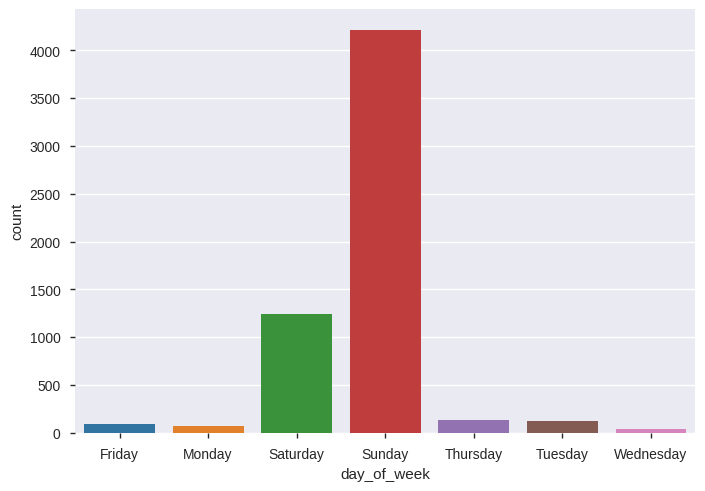

In [ ]:
sns.barplot(x = "day_of_week",y = "count", data = plot )
plt.show()


In [ ]:
Cruce_final=Cruce_final.drop('uds_previsionMedia',axis=1)

In [ ]:
Cruce_final['semana']=Cruce_final['fecha'].dt.week
Cruce_final['anyo']=Cruce_final['fecha'].dt.year

**Los nulos restantes se proceden a tratan por tipo de día de la semana del año al que pertenecen. Es decir para los nulos que se correspondan a días desde Lunes a Jueves se cogen la media de las previsiones del último año de esos días.Con Sabados se obtiene la media del Viernes y Domingo y con Domingos la media del viernes y Sabado. Se inputa de esta manera debido a las tendencias en el sector retail donde se consume más los días no laborales**

In [ ]:
Domingos=Cruce_final.loc[Cruce_final["weekday"].isin([4,5])].groupby(['Producto','anyo','semana'], dropna=False, as_index=False).mean().round(0)

In [ ]:
Diario=Cruce_final.loc[Cruce_final["weekday"].isin([0,1,2,3])].groupby(['Producto','anyo','semana'], dropna=False, as_index=False).mean().round(0)

In [ ]:
Sabados=Cruce_final.loc[Cruce_final["weekday"].isin([4,6])].groupby(['Producto','anyo','semana'], dropna=False, as_index=False).mean().round(0)

In [ ]:
Viernes=Cruce_final.groupby(['Producto','anyo','semana'], dropna=False, as_index=False).mean().round(0)

In [ ]:
Cruce_final.head()

Producto      fecha  udsPrevisionEmpresa day_of_week  weekday  semana  anyo
0         1 2019-02-27               7745.0   Wednesday        2       9  2019
1         1 2019-02-28              10824.0    Thursday        3       9  2019
2         1 2019-03-01              11197.0      Friday        4       9  2019
3         1 2019-03-02              17076.0    Saturday        5       9  2019
4         1 2019-03-03                  NaN      Sunday        6       9  2019

In [ ]:
Domingos.head()

Producto  anyo  semana  udsPrevisionEmpresa  weekday
0         1  2019       9              14136.0      4.0
1         1  2019      10              47542.0      4.0
2         1  2019      11               5458.0      4.0
3         1  2019      12              43592.0      4.0
4         1  2019      13              64090.0      4.0

In [ ]:
def inputNulos2(df,Cruce_final,dia):
  df=df.rename(columns = { 'udsPrevisionEmpresa':'Previsiones_input'})
  df=df.drop('weekday',axis=1)
  Inputacion=pd.merge(Cruce_final, df[["Producto","anyo",'semana','Previsiones_input']], on=['Producto',"anyo",'semana'], how='left')
  Inputacion.loc[(Inputacion["udsPrevisionEmpresa"].isna())&(Inputacion["weekday"]==dia),'udsPrevisionEmpresa']=Inputacion["Previsiones_input"]
  Inputacion=Inputacion.drop('Previsiones_input',axis=1)
  return Inputacion

In [ ]:
Cruce_domingo=inputNulos2(Domingos,Cruce_final,6)

In [ ]:
Cruce_Lunes=inputNulos2(Diario,Cruce_domingo,0)
Cruce_Martes=inputNulos2(Diario,Cruce_Lunes,1)
Cruce_X=inputNulos2(Diario,Cruce_Lunes,2)
Cruce_Jueves=inputNulos2(Diario,Cruce_X,3)

In [ ]:
Cruce_Sabados=inputNulos2(Sabados,Cruce_Jueves,5)

In [ ]:
Cruce_Total_final=inputNulos2(Viernes,Cruce_Sabados,4)

Aún con estos tratamientos se observan que aún quedan 300 registros nulos, para estos registros se inputan con el valor más cercano

In [ ]:
Cruce_Total_final.loc[Cruce_Total_final["udsPrevisionEmpresa"].isna()].groupby(['day_of_week'], dropna=False).size().reset_index(name='count')

day_of_week  count
0      Friday      1
1    Saturday     96
2      Sunday     96
3     Tuesday    126

In [ ]:
Cruce_Total_final=Cruce_Total_final.fillna(method='ffill')

In [ ]:
Cruce_Total_final.head()

Producto      fecha  udsPrevisionEmpresa day_of_week  weekday  semana  anyo
0         1 2019-02-27               7745.0   Wednesday        2       9  2019
1         1 2019-02-28              10824.0    Thursday        3       9  2019
2         1 2019-03-01              11197.0      Friday        4       9  2019
3         1 2019-03-02              17076.0    Saturday        5       9  2019
4         1 2019-03-03              14136.0      Sunday        6       9  2019

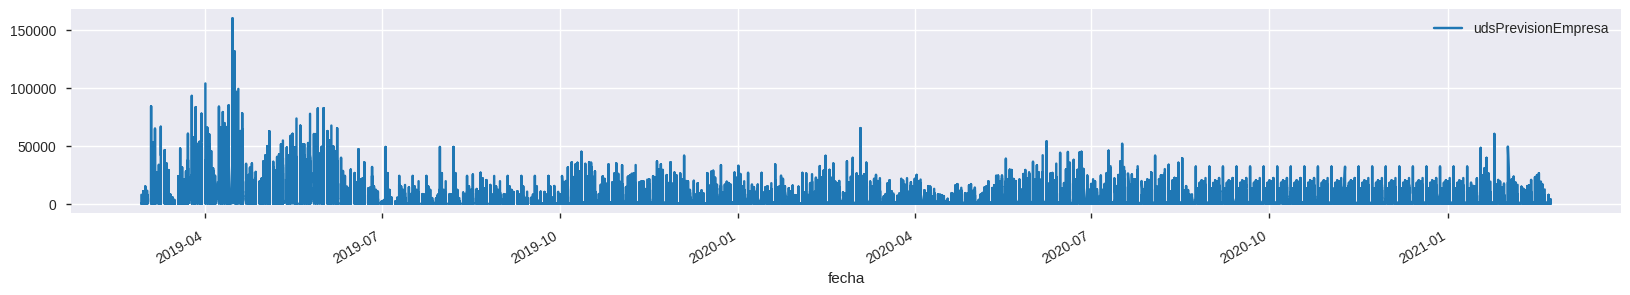

In [ ]:
Cruce_final.plot(x='fecha', y='udsPrevisionEmpresa')
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
Cruce_final.head()

Producto      fecha  udsPrevisionEmpresa day_of_week  weekday  semana  anyo
0         1 2019-02-27               7745.0   Wednesday        2       9  2019
1         1 2019-02-28              10824.0    Thursday        3       9  2019
2         1 2019-03-01              11197.0      Friday        4       9  2019
3         1 2019-03-02              17076.0    Saturday        5       9  2019
4         1 2019-03-03                  NaN      Sunday        6       9  2019

In [ ]:
Cruce_final.to_csv("/content/gdrive/MyDrive/TFM/3/Previsiones_Filtrado.csv", index = False)




---



---



---




## C Preparación de los datos - Stock

### 3.3.0 Generación Serie Historica

In [ ]:
stock.head()

fecha  Producto  udsStock
0 2019-06-05         1      9166
1 2019-06-11         1      1464
2 2019-06-12         1      3376
3 2019-06-13         1      3632
4 2019-06-14         1      1931

In [ ]:
stock.isna().sum()

fecha       0
Producto    0
udsStock    0
dtype: int64

In [ ]:
stock[["fecha","Producto"]].duplicated().sum()

0

In [ ]:
stock=stock.sort_values(by=["Producto","fecha"])

In [ ]:
prueba_stock=stock[['fecha']].groupby(['fecha']).size()

In [ ]:
prueba_stock.head(20)

fecha
2019-06-05    58
2019-06-11    59
2019-06-12    59
2019-06-13    58
2019-06-14    59
2019-06-15    55
2019-06-16    56
2019-06-17    55
2019-06-18    62
2019-06-19    60
2019-06-20    58
2019-06-21    57
2019-06-22    54
2019-06-25    56
2019-07-01    55
2019-07-03    54
2019-07-10    53
2019-07-11    60
2019-07-12    56
2019-07-14    59
dtype: int64

In [ ]:
fecha_min=stock.groupby(['Producto'], as_index=False)[['fecha']].min()
fecha_max=stock.groupby(['Producto'], as_index=False)[['fecha']].max()

In [ ]:
fecha_min=fecha_min.rename(columns = { 'fecha':'fecha_min'})

In [ ]:
fecha_max=fecha_max.rename(columns = { 'fecha':'fecha_max'})

In [ ]:
fecha_max.shape

(67, 2)

In [ ]:
Cruce_ini_stock=pd.merge(fecha_min, fecha_max, on=["Producto"], how='inner',left_index=False, right_index=False)

In [ ]:
Cruce_ini_stock.head()

Producto  fecha_min  fecha_max
0         1 2019-06-05 2020-09-03
1         2 2019-06-05 2021-03-24
2         3 2019-06-05 2021-03-24
3         4 2019-06-05 2021-03-24
4         5 2019-06-15 2021-03-24

In [ ]:
fechas_stock= Cruce_ini_stock.apply(lambda s: pd.date_range(s['fecha_min'], s['fecha_max'], freq='D').tolist(), 1)
Cruce_ini_stock['fecha']=fechas_stock
Cruce_ini_stock = Cruce_ini_stock.explode('fecha')

In [ ]:
Cruce_ini_stock.head()

Producto  fecha_min  fecha_max      fecha
0         1 2019-06-05 2020-09-03 2019-06-05
0         1 2019-06-05 2020-09-03 2019-06-06
0         1 2019-06-05 2020-09-03 2019-06-07
0         1 2019-06-05 2020-09-03 2019-06-08
0         1 2019-06-05 2020-09-03 2019-06-09

In [ ]:
Cruce_ini_stock = Cruce_ini_stock.reset_index(drop = True)

In [ ]:
Cruce_final_stock=pd.merge(Cruce_ini_stock[["Producto","fecha"]], stock, on=['Producto','fecha'], how='left')

### 3.3.1 Estudio de Registros Nulos

Aunque no se puede predecir la demanda con el stock se decide tratar el fichero para observan las tendencias de la empresa para extraer información de cara al desarrollo del modelo. Se inputan los datos nulos de diversas maneras para observan las tendencias que ha tenido la empresa en el tiempo. Se realizan diferentes tecnicas de interpolación

In [ ]:
Cruce_final_stock.isna().sum()

Producto        0
fecha           0
udsStock    11074
dtype: int64

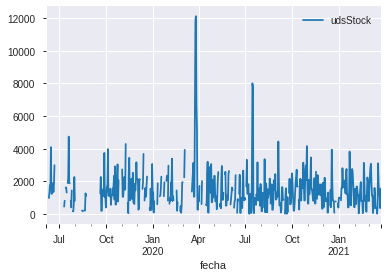

In [ ]:
%matplotlib inline

Cruce_final_stock.loc[Cruce_final_stock["Producto"]==2].plot(x='fecha', y='udsStock')
plt.show()


**Ejemplo con el producto id 387**

In [ ]:

df = Cruce_final_stock.loc[Cruce_final_stock["Producto"]==37]
df = df.set_index('fecha')
df=df[['udsStock']]

In [ ]:
df.isna().sum()

udsStock    448
dtype: int64

In [ ]:
df.notna().sum()

udsStock    200
dtype: int64

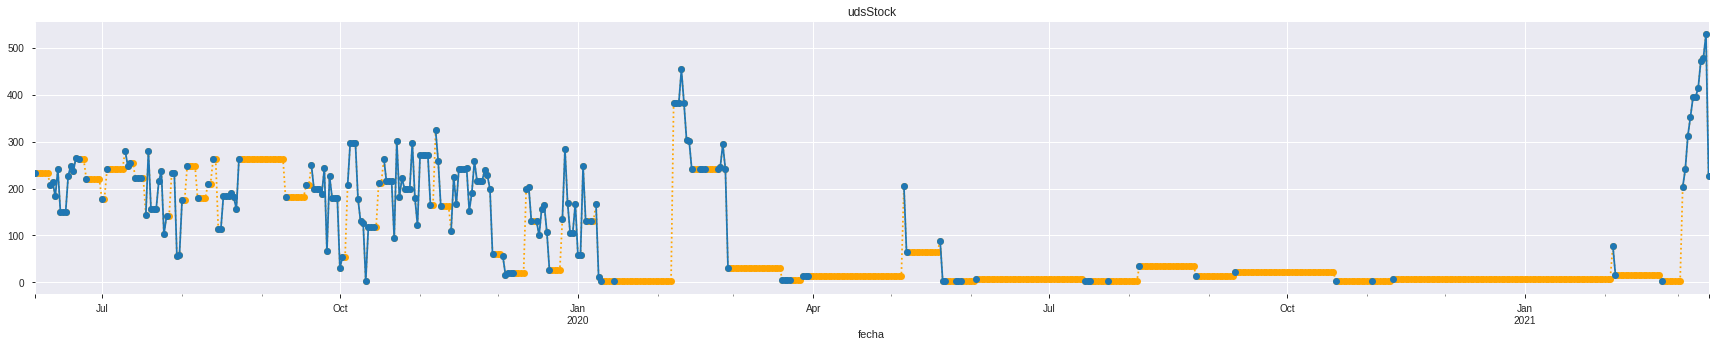

In [ ]:


### Forward Fill
#  ffill method
ffill_imputed = df.copy(deep=True)

ffill_imputed.fillna(method='ffill',inplace=True)

# Plot el imputado con naranja 
ffill_imputed['udsStock'].plot(color='orange', marker='o', linestyle='dotted', figsize=(30, 5))
df['udsStock'].plot(title='udsStock', marker='o', figsize=(30, 5))

plt.show()

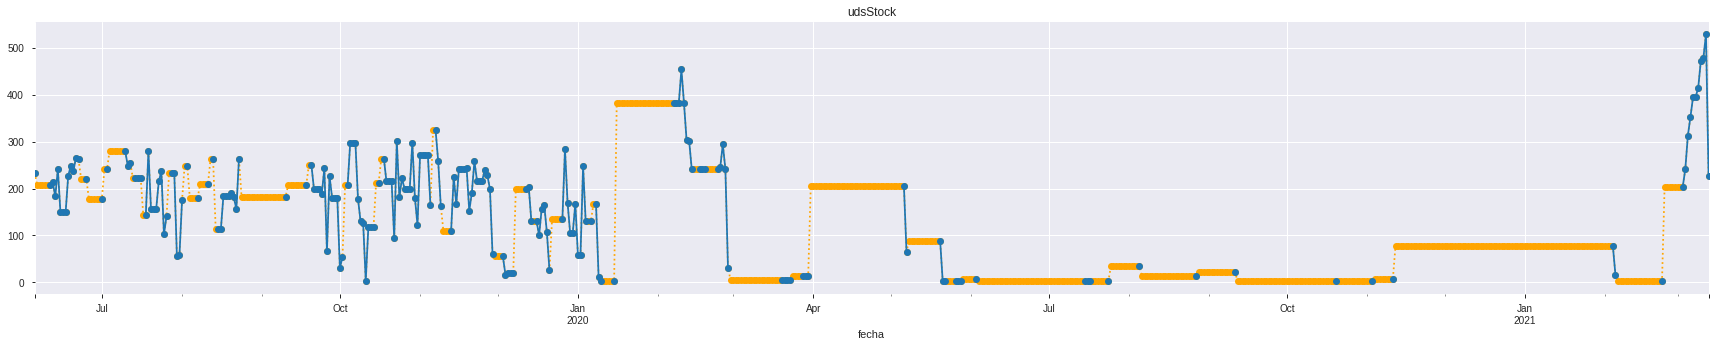

In [ ]:

### Back Fill Fill
#  bfill methodo
bfill_imputed = df.copy(deep=True)

bfill_imputed.fillna(method='bfill',inplace=True)

# Plot el imputado con naranja 
bfill_imputed['udsStock'].plot(color='orange', marker='o', linestyle='dotted', figsize=(30, 5))

df['udsStock'].plot(title='udsStock', marker='o', figsize=(30, 5))

plt.show()



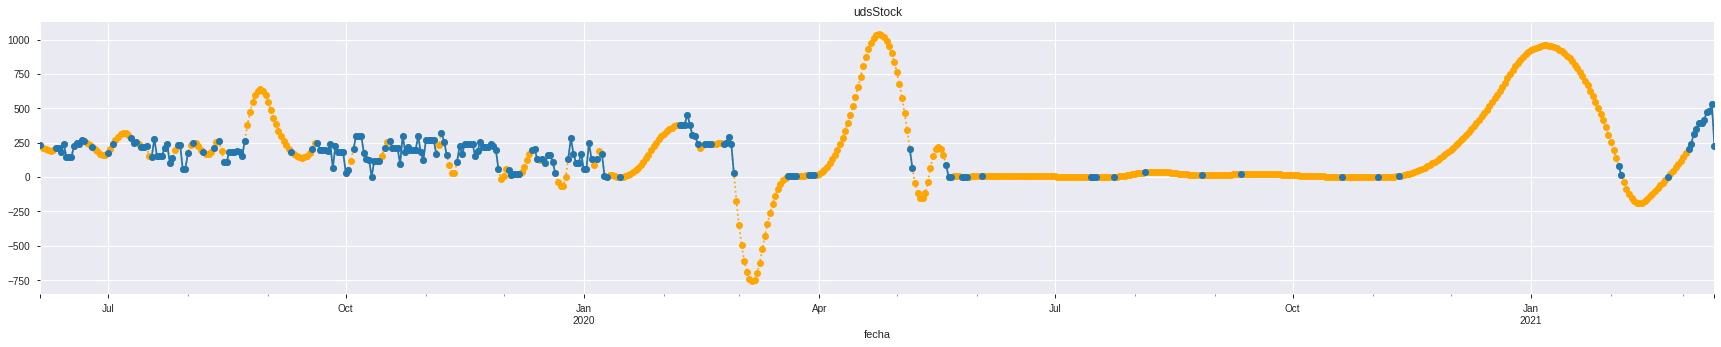

In [ ]:
# Interpolado de manera quadratically

quadratic_imput=df.copy(deep=True)

quadratic_imput.interpolate(method='quadratic', inplace=True)

quadratic_imput['udsStock'].plot(color='orange', marker='o', linestyle='dotted', figsize=(30, 5))

df['udsStock'].plot(title='udsStock', marker='o', figsize=(30, 5))

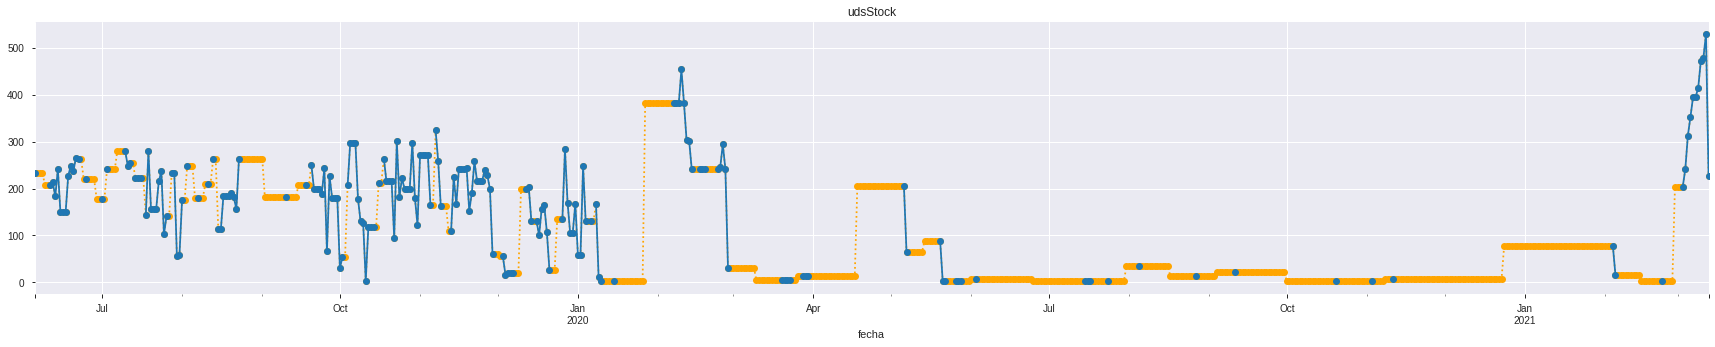

In [ ]:


# Interpolado the NaNs con nearest method

nearest_imput=df.copy(deep=True)

nearest_imput.interpolate(method='nearest', inplace=True)

nearest_imput['udsStock'].plot(color='orange', marker='o', linestyle='dotted', figsize=(30, 5))

df['udsStock'].plot(title='udsStock', marker='o', figsize=(30, 5))



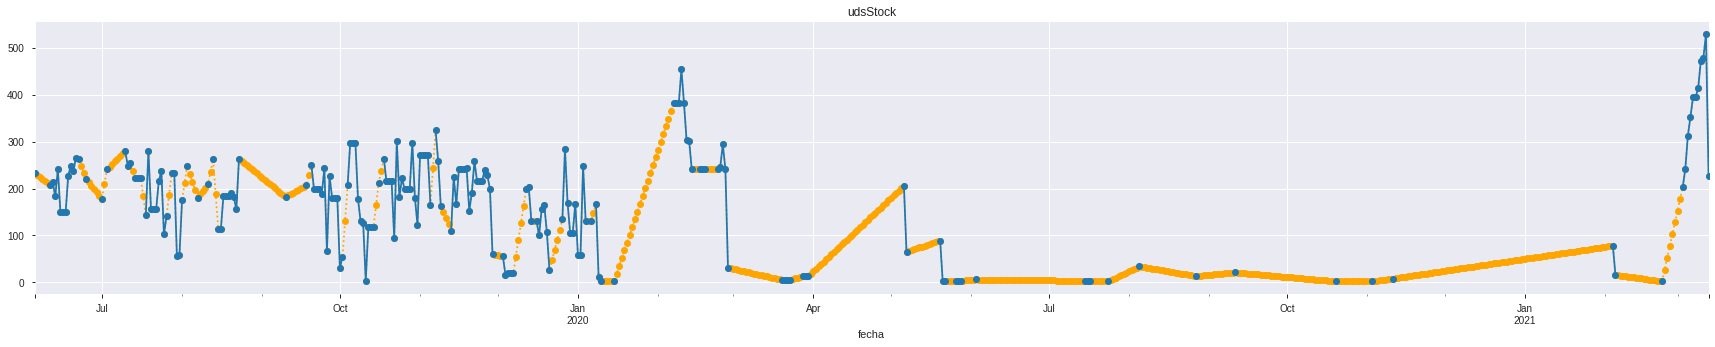

In [ ]:
 #Interpolado de manera linear

linear_imput=df.copy(deep=True)

linear_imput.interpolate(method='linear', inplace=True)

linear_imput['udsStock'].plot(color='orange', marker='o', linestyle='dotted', figsize=(30, 5))

df['udsStock'].plot(title='udsStock', marker='o', figsize=(30, 5))

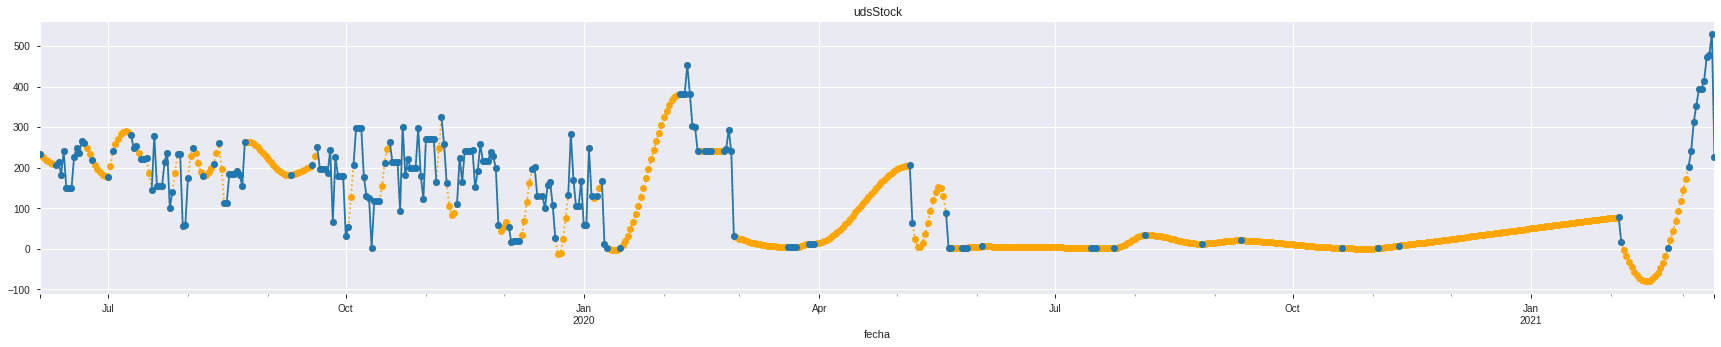

In [ ]:

akima_imput=df.copy(deep=True)

akima_imput.interpolate(method='akima', inplace=True)

akima_imput['udsStock'].plot(color='orange', marker='o', linestyle='dotted', figsize=(30, 5))

df['udsStock'].plot(title='udsStock', marker='o', figsize=(30, 5))

**Se observa las diferentes interpolaciones en una misma imagen**

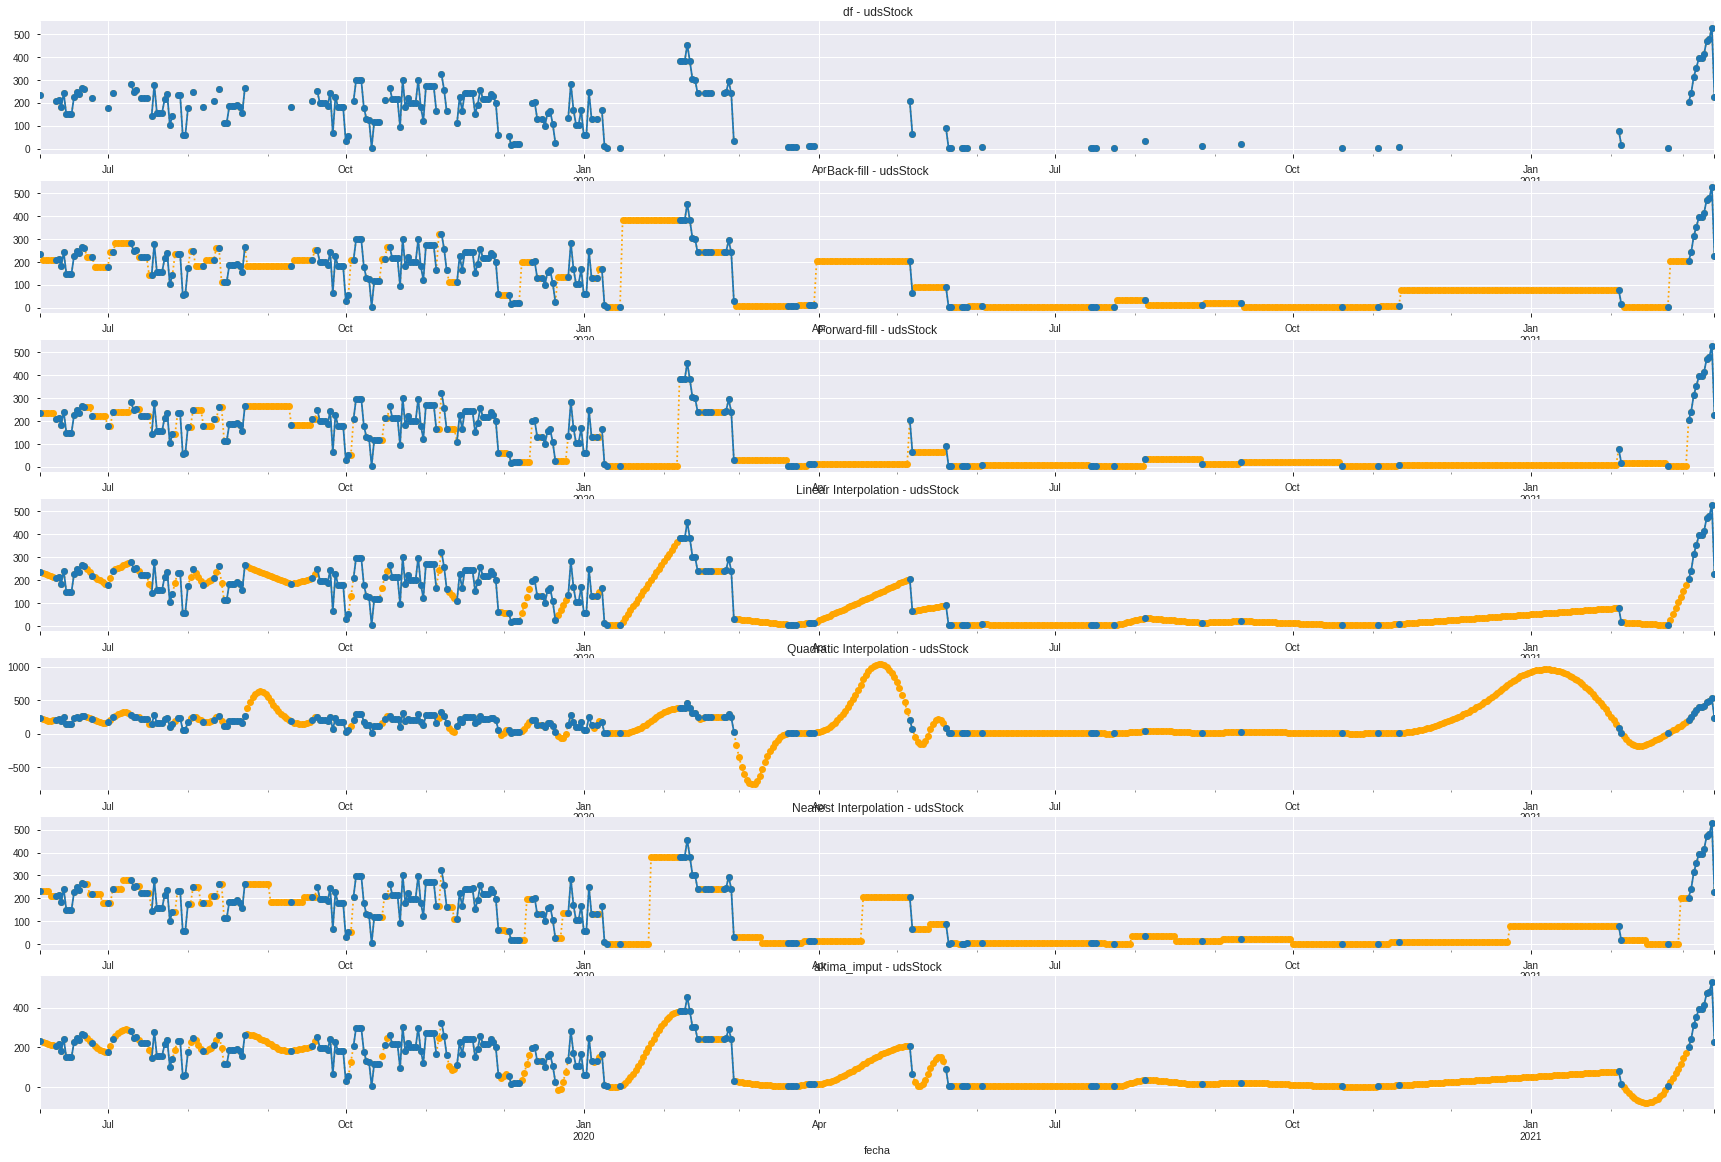

In [ ]:


fig, axes = plt.subplots(7, 1, figsize=(30, 20))

interpolations = {'df': df, 'Back-fill':bfill_imputed, 'Forward-fill':ffill_imputed,
                  'Linear Interpolation': linear_imput, 'Quadratic Interpolation': quadratic_imput, 
                  'Nearest Interpolation': nearest_imput,'akima_imput':akima_imput}

for ax, df_key in zip(axes, interpolations):
  interpolations[df_key].udsStock.plot(color='orange', marker='o', 
                                 linestyle='dotted', ax=ax)
  df.udsStock.plot(title=df_key + ' - udsStock', marker='o', ax=ax)
  
plt.show()



### 3.3.2 Inputación de Nulos

Una vez visualizados las diferentes interpolaciones se realiza la inputación de nulos por medio de la interpolación akima

In [ ]:
Productos=np.unique(Cruce_final["Producto"])

In [ ]:
Cruce_final_stock = Cruce_final_stock.set_index('fecha')

In [ ]:
for i in Productos:
  # Import Data
  df = Cruce_final_stock.loc[Cruce_final_stock["Producto"]==i]
  #df = df.set_index('fecha')
  df=df[['udsStock']]
  nulos=df.isna().sum()[0]
  no_nulos=df.notna().sum()[0]
  if(( nulos !=0)& (no_nulos> nulos)):
    akima_imput=df.copy(deep=True)
    akima_imput.interpolate(method='akima', inplace=True)
    print(akima_imput)
    Cruce_final_stock.loc[(Cruce_final_stock["udsStock"].isna())& (Cruce_final_stock["Producto"]==i),'udsStock']=akima_imput["udsStock"]
    print(Cruce_final_stock.head(5))
  else:
    if (nulos==0):
      print("NO hay registros del producto: ",i)
    else:
      print("Mayor nulos que registros en el producto: ",i)




               udsStock
fecha                  
2019-06-05  9166.000000
2019-06-06  6480.379278
2019-06-07  4242.858135
2019-06-08  2537.948102
2019-06-09  1450.160714
...                 ...
2020-08-30   761.000000
2020-08-31   761.000000
2020-09-01   139.000000
2020-09-02   139.000000
2020-09-03   139.000000

[457 rows x 1 columns]
            Producto     udsStock
fecha                            
2019-06-05         1  9166.000000
2019-06-06         1  6480.379278
2019-06-07         1  4242.858135
2019-06-08         1  2537.948102
2019-06-09         1  1450.160714
               udsStock
fecha                  
2019-06-05  1925.000000
2019-06-06  1552.473997
2019-06-07  1238.472346
2019-06-08  1003.359584
2019-06-09   867.500247
...                 ...
2021-03-20  1928.000000
2021-03-21  1150.000000
2021-03-22  1150.000000
2021-03-23   360.000000
2021-03-24  1558.000000

[659 rows x 1 columns]
            Producto     udsStock
fecha                            
2019-06-05         1  

In [ ]:
Cruce_final_stock.isna().sum()

Producto       0
udsStock    2777
dtype: int64

In [ ]:
Cruce_final_stock['fecha'] = Cruce_final_stock.index


In [ ]:
Cruce_final_stock.reset_index(level=0, inplace=True)

In [ ]:
 # Productos que no hay datos suficientes 37,53,58,80,81,83,85,92,93,99

In [ ]:
Cruce_final_stock.loc[Cruce_final_stock["udsStock"].isna()].groupby(['Producto'], dropna=False).size().reset_index(name='count')

Producto  count
0        37    448
1        53    202
2        58    553
3        80    552
4        85    557
5        99    465



---



---



---



## D  Preparación de los datos - Fichero Ventas

### 3.3.0 Convertir la variable fecha a variable temporal y comprobaciones

In [14]:
ventas['fecha'] = pd.to_datetime(ventas['fecha'], format='%Y%m%d')


In [ ]:
ventas.head()

fecha  producto  udsVenta
0 2015-06-29         1      3266
1 2015-06-30         1      4199
2 2015-07-01         1     14463
3 2015-07-02         1      4199
4 2015-07-03         1      7932

In [5]:
ventas=ventas.sort_values(by=["producto","fecha"])

In [6]:
ventas.isna().sum()

fecha       0
producto    0
udsVenta    0
dtype: int64

In [7]:
ventas[["fecha","producto"]].duplicated().sum()

0

In [8]:
ventas[["fecha","producto"]].isna().sum()

fecha       0
producto    0
dtype: int64

### 3.3.1 Generación de Serie Para establecer los dias que no hay ventas

En caso de valor faltante se considera día de no venta, se genera la serie temporal de manera similar a los anteriores ficheros

In [15]:
fecha_min=ventas.groupby(['producto'], as_index=False)[['fecha']].min()
fecha_max=ventas.groupby(['producto'], as_index=False)[['fecha']].max()

In [16]:
fecha_min=fecha_min.rename(columns = { 'fecha':'fecha_min'})

In [17]:
fecha_max=fecha_max.rename(columns = { 'fecha':'fecha_max'})

In [18]:
st_ventas=pd.merge(fecha_min, fecha_max, on=["producto"], how='inner',left_index=False, right_index=False)

In [19]:
fechas_ventas= st_ventas.apply(lambda s: pd.date_range(s['fecha_min'], s['fecha_max'], freq='D').tolist(), 1)
st_ventas['fecha']=fechas_ventas
st_ventas = st_ventas.explode('fecha')

In [20]:
Cruce_ventas=pd.merge(st_ventas[["producto","fecha"]], ventas, on=['producto','fecha'], how='left')

In [21]:
Cruce_ventas.isna().sum()

producto        0
fecha           0
udsVenta    41412
dtype: int64

In [22]:
Cruce_ventas.tail()

producto      fecha  udsVenta
139818        99 2021-03-19     486.0
139819        99 2021-03-20       NaN
139820        99 2021-03-21       NaN
139821        99 2021-03-22       NaN
139822        99 2021-03-23     146.0

In [23]:
Cruce_ventas["udsVenta"].fillna(0,inplace=True)

In [25]:
ventas=Cruce_ventas

### 3.3.2 Estudio de Outliers

Se estudia los valores atipicos de ventas en la serie temporal. Hay que tener cuidado a la hora de tratar los nulos

In [ ]:
Total_Ventas=ventas[["fecha","udsVenta"]]

In [ ]:
Total_Ventas1=Total_Ventas.groupby('fecha').sum('udsVenta')

In [ ]:
Total_Ventas1["fecha"]=Total_Ventas1.index

Se observa que existe un outlier en 2016, ya que en la serie en periodos siguientes no se observa tal cantidad de unidades vendidas y a priori no es una fecha destacada en el calendario. Se procede a truncarlo con el maximo anterior. Se buscan los productos que corresponden a esta fecha y se estudia cada uno en detalle para hacer el truncado

<Figure size 1440x720 with 0 Axes>

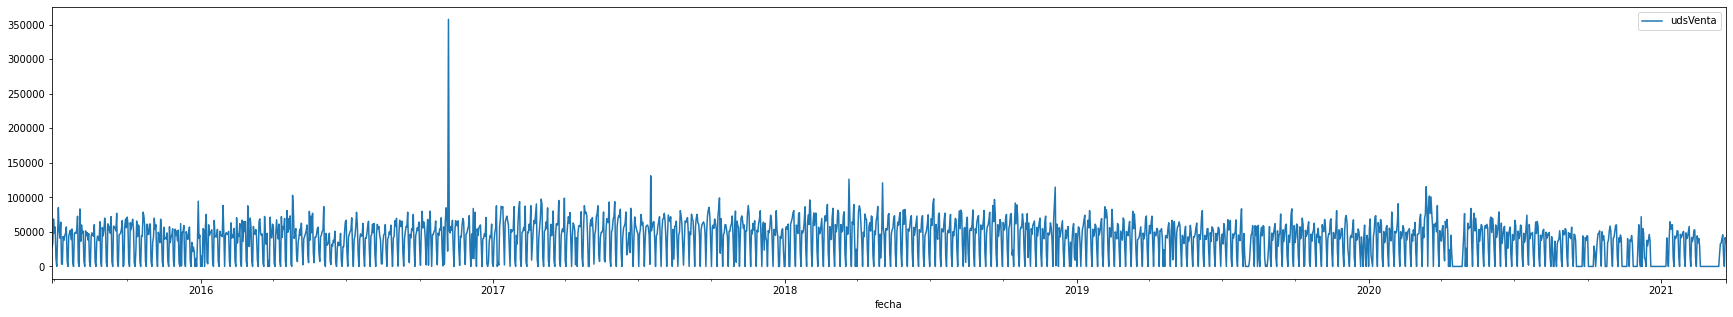

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
Total_Ventas1.plot(x='fecha', y='udsVenta', figsize=(30, 5))
plt.show()


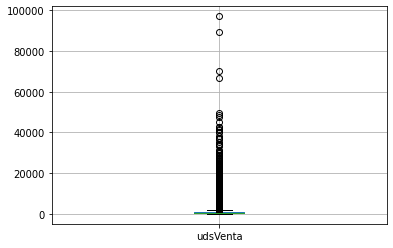

In [ ]:
Total_Ventas.loc[Total_Ventas["udsVenta"]>1].boxplot()

In [ ]:
Outliers_2016= ventas.loc[(ventas.fecha =='2016-11-06') ]

In [ ]:
Outliers_2016.loc[(Outliers_2016.udsVenta > 60000) ]

producto      fecha  udsVenta
496           1 2016-11-06   97044.0
10559         9 2016-11-06   89113.0
22655        15 2016-11-06   69984.0

In [ ]:
Producto1= ventas.loc[(ventas.producto ==1) ]

In [ ]:
Producto9 	= ventas.loc[(ventas.producto ==9) ]

In [ ]:
Producto15 	= ventas.loc[(ventas.producto ==15) ]

In [ ]:
Producto1['udsVenta'].describe()

count     1891.000000
mean      4309.574299
std       6034.646271
min          0.000000
25%        311.000000
50%       3266.000000
75%       5599.000000
max      97044.000000
Name: udsVenta, dtype: float64

In [ ]:
Producto9['udsVenta'].describe()

count     2095.000000
mean      1827.775179
std       3068.393101
min          0.000000
25%          0.000000
50%       1400.000000
75%       2333.000000
max      89113.000000
Name: udsVenta, dtype: float64

In [ ]:
Producto15['udsVenta'].describe()

count     2094.000000
mean      1010.783190
std       2102.022218
min          0.000000
25%          0.000000
50%        622.000000
75%       1400.000000
max      69984.000000
Name: udsVenta, dtype: float64

In [ ]:
Producto9.loc[(Producto9["fecha"]> '2016-01-31' )&(Producto9["fecha"]< '2020-12-31' )&(Producto9["udsVenta"]>20000 )]

producto      fecha  udsVenta
10359         9 2016-04-20   34059.0
10361         9 2016-04-22   24728.0
10470         9 2016-08-09   20995.0
10526         9 2016-10-04   21462.0
10559         9 2016-11-06   89113.0
10631         9 2017-01-17   23795.0
10694         9 2017-03-21   22861.0
11670         9 2019-11-22   23846.0

In [ ]:
Producto15.loc[(Producto15["fecha"]> '2016-01-31' )&(Producto15["fecha"]< '2020-12-31' )&(Producto15["udsVenta"]>20000 )]

producto      fecha  udsVenta
22453        15 2016-04-18   26594.0
22594        15 2016-09-06   22395.0
22655        15 2016-11-06   69984.0
22664        15 2016-11-15   20995.0

In [ ]:
Producto1.loc[(Producto1["fecha"]> '2017-01-31' )&(Producto1["fecha"]< '2020-12-31' )&(Producto1["udsVenta"]>40000 )]

producto      fecha  udsVenta
666          1 2017-04-25   41057.0
997          1 2018-03-22   66718.0
1039         1 2018-05-03   45256.0
1135         1 2018-08-07   40124.0
1177         1 2018-09-18   42457.0
1205         1 2018-10-16   40124.0
1255         1 2018-12-05   47589.0
1317         1 2019-02-05   41524.0

In [26]:
ventas.loc[(ventas.index==496),'udsVenta']=66718

In [27]:
ventas.loc[(ventas.index==10559),'udsVenta']=34059

In [28]:
ventas.loc[(ventas.index==22655),'udsVenta']=26594

In [ ]:
Total_Ventas=ventas[["fecha","udsVenta"]]

<Figure size 1440x720 with 0 Axes>

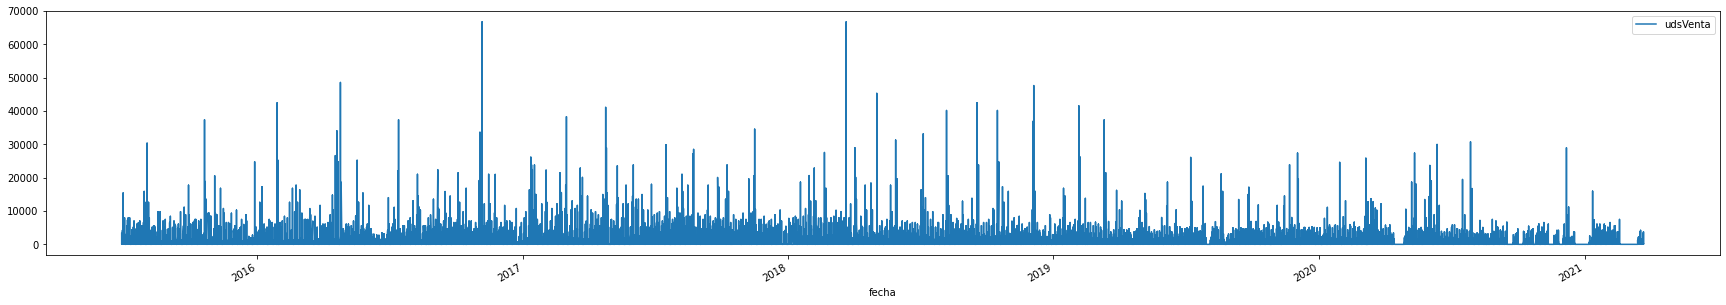

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
Total_Ventas.plot(x='fecha', y='udsVenta', figsize=(30, 5))
plt.show()



```
# This is formatted as code
```

### 3.3.3 Analisis descripctivo y Estadistico

#### Estudio de Ventas Anuales

Se estudia la tendencia anual del volumen de ventas de la empresa del sector retail. Se empieza vislumbrar que el escenario Covid ha afectado a las ventas

In [ ]:
Total_Ventas2=Total_Ventas.groupby('fecha').sum('udsVenta')

In [ ]:
checkin_year_sigma = Total_Ventas2.groupby(pd.Grouper(freq='Y')).sum()

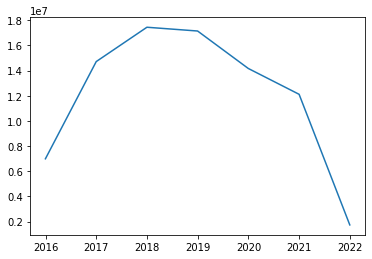

In [ ]:
plt.plot(checkin_year_sigma.index, checkin_year_sigma.udsVenta)

In [ ]:
Total_Ventas_año=Total_Ventas.groupby('fecha').sum('udsVenta')

<span style="color:blue"> Se decide realizar foco en el año 2020 para ver que ocurre exactamente en ese periodo y si se podría usar para el modelo solución</span>

In [ ]:
df_2020 = Total_Ventas_año.loc[(Total_Ventas_año.index >'2020-01-01') & (Total_Ventas_año.index<'2020-12-31')]

In [ ]:
df_covid = Total_Ventas_año.loc[(Total_Ventas_año.index >'2020-04-01') & (Total_Ventas_año.index<'2021-01-31')]

Se observa que en el año 2020 la empresa a permanecido cerrada varios días y se estudia si es un caso atipico debido al covid o es un caso general

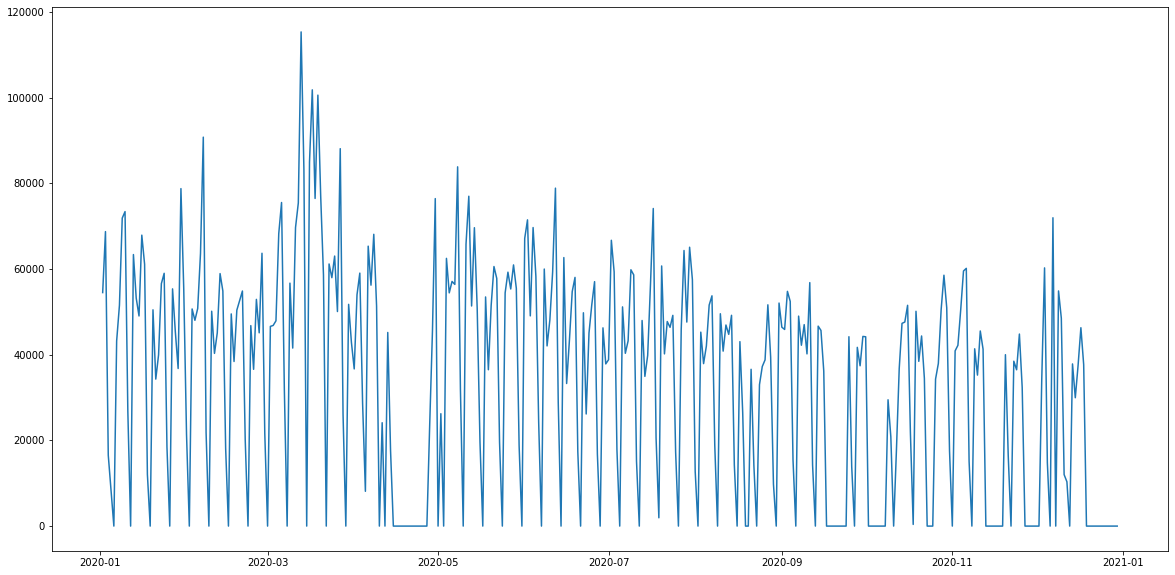

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(df_2020.index, df_2020.udsVenta)


#### Estudio de ventas con frecuencia mensual

Dada la gráfica del ejercicio anterior se decide observar si el número de ventas tiene cierta estacionalidad según en el mes de venta. Se decide comparar todos los meses para visualizar el problema

En el gráfico se observa poca variabilidad en el escenario antes del Covid, Se observa también que justo antes del Covid la empresa estaba llegando a su máximo y la pandemia provoco una caida sin precedentes.

In [ ]:
meses =Total_Ventas_año.resample('M').mean()

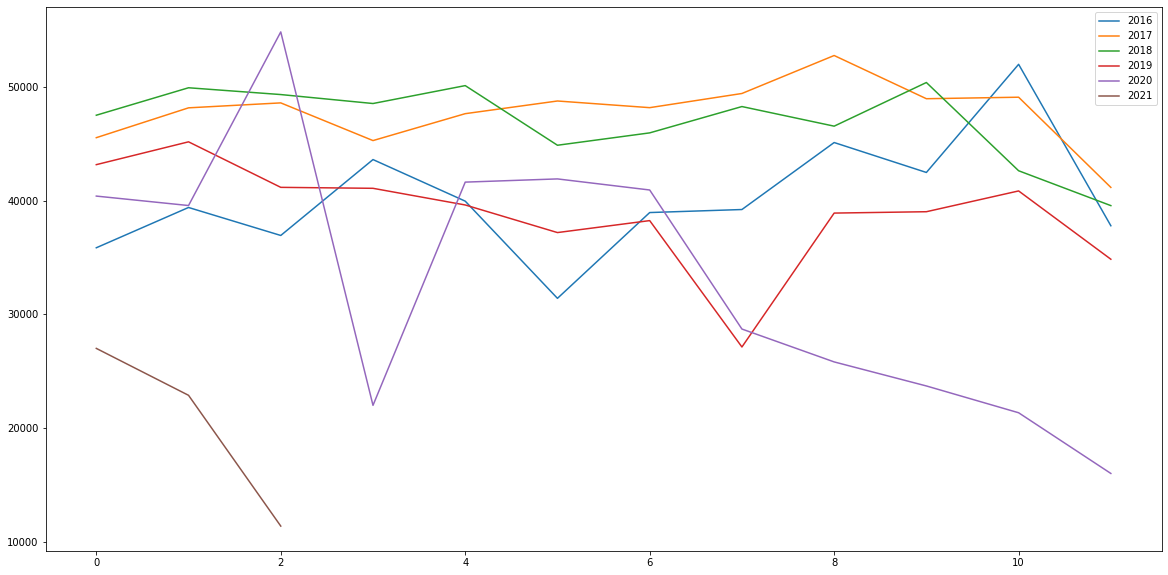

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(meses['2016'].values, label='2016')
plt.plot(meses['2017'].values, label='2017')
plt.plot(meses['2018'].values, label='2018')
plt.plot(meses['2019'].values, label='2019')
plt.plot(meses['2020'].values, label='2020')
plt.plot(meses['2021'].values, label='2021')
plt.legend()

#### Estudio de Descomposición temporal

La descomposición de las series temporales implica pensar en una serie como una combinación de componentes de tendencia, estacionalidad y ruido.

La descomposición proporciona un modelo abstracto útil para pensar en las series temporales en general y para comprender mejor los problemas durante el análisis y la previsión de las series temporales.

A grandes rasgos se pueden definir los componentes como:
* Estacionalidad: describe la señal periódica de la serie temporal.
* Tendencia: describe si la serie temporal disminuye, es constante o aumenta con el tiempo.
* Ruido: describe lo que queda tras la separación de la estacionalidad y la tendencia de la serie temporal. En otras palabras, es la variabilidad de los datos que no puede ser explicada por el modelo.

Para estudiar la serie temporal se usa el paquete *seasonal_descompose* Se puede establecer que el modelo sea aditivo o multiplicativo. Una regla general para seleccionar el modelo adecuado es ver en el gráfico si la tendencia y la variación estacional son relativamente constantes en el tiempo, es decir, lineales. En caso afirmativo, seleccionaremos el modelo aditivo. En caso contrario, si la tendencia y la variación estacional aumentan o disminuyen con el tiempo, utilizaremos el modelo Multiplicativo.
En este caso como la estacional es constante estudiamos la serie temporal como si fuera aditivo

##### Descomposición de la serie Total

Se analiza el con periodo mensual  la serie temporal.En este caso al observar los datos de las series temporales es difícil identificar la estacionalidad. Se procede a descomponer la serie temporal para  tener una visión más clara de los componentes, ya que es más fácil analizar.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


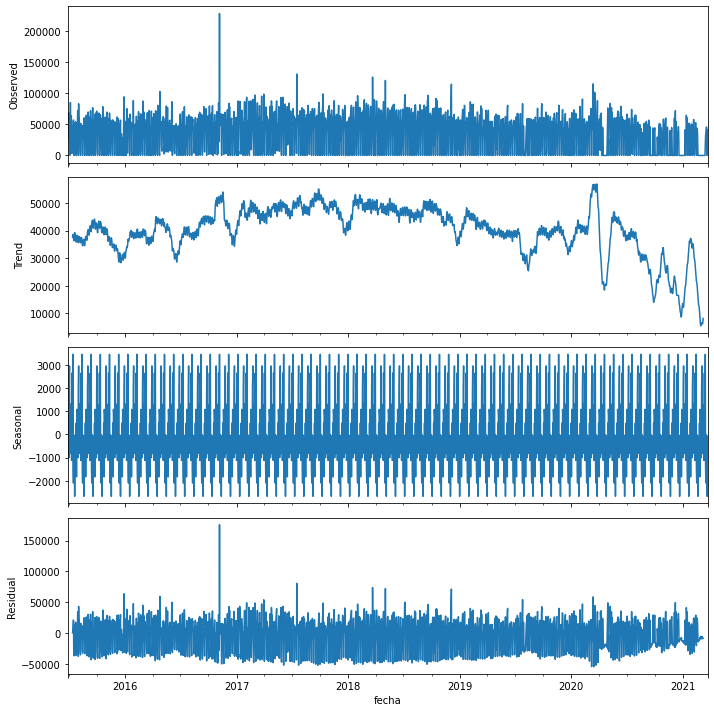

In [ ]:


plt.rcParams["figure.figsize"] = (10,10)
res = seasonal_decompose(Total_Ventas_año['udsVenta'],model='additive', freq=30)
res.plot()
plt.show()


##### Descomposición de la serie temporal año 2020


En la descomposición temporal se observa el parón por el inicio covid y las diferentes olas de contagios que ha habido en la población. Se sigue observando un patron estacional y se busca si se repite en diferentes años que no tengan este escenario de incertidumbre

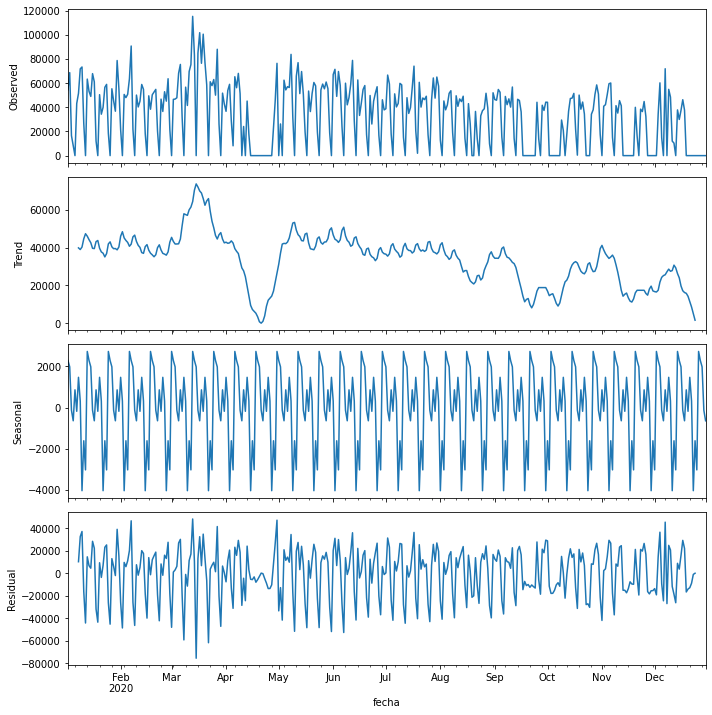

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
res = seasonal_decompose(df_2020['udsVenta'],model='additive', freq=12)
res.plot()
plt.show()

##### Descomposición de la serie temporal año 2019


En la serie del año 2019 se empieza vislumbrar que la tendencia sigue la serie temporal ya que se observa como en agosto y fin de año la tendencia cae bruscamente. La componente estacionaria no cambia con el paso del tiempo y se decide estudiar la descomposición del año 2018 para ver si es recurrente este comportamiento

In [ ]:
df_2019 = Total_Ventas_año.loc[(Total_Ventas_año.index >'2019-01-01') & (Total_Ventas_año.index<'2019-12-31')]

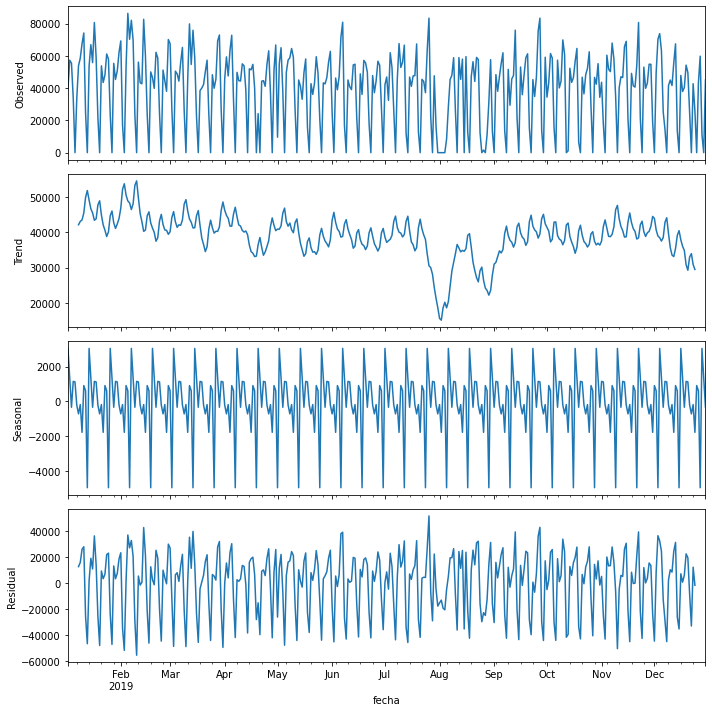

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
res = seasonal_decompose(df_2019['udsVenta'],model='additive', freq=12)
res.plot()
plt.show()

##### Descomposición de la serie temporal año 2018


La descomposición de la serie temporal de 2018 nos valida la hipotesis de 2019, tiene la misma componente estacionaria que en 2019 y además la tendencia cae a final de año. También se tiene en cuenta las Navidades y Agosto como caídas en la demanda

In [ ]:
df_2018 = Total_Ventas_año.loc[(Total_Ventas_año.index >'2018-01-01') & (Total_Ventas_año.index<'2018-12-31')]

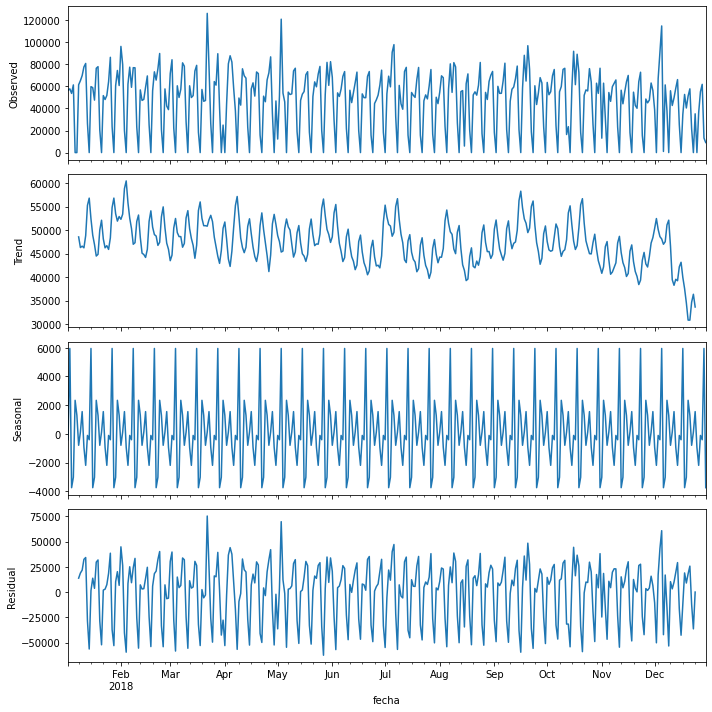

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
res = seasonal_decompose(df_2018['udsVenta'],model='additive', freq=12)
res.plot()
plt.show()

In [ ]:
Total_Ventas_año['m'] = Total_Ventas_año['fecha'].dt.month


In [ ]:
wp4=Total_Ventas_año[['m','udsVenta']].groupby('m').mean('udsVenta')

<Figure size 1440x720 with 0 Axes>

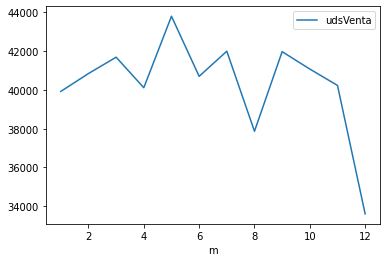

In [ ]:
### Media de Ventas por Mes

plt.figure(figsize=(20,10))

wp4.plot()
plt.show()

##### Descomposición serie mensual

Estudiados un mes aleatorio para darnos cuenta en detalle de la componente estacional que tiene un periodo de 7 días, siendo el fin de semana los días que menos se producen ventas. Se procede al estudio de periodos semanales

In [ ]:
df_2020_Enero = Total_Ventas_año.loc[(Total_Ventas_año.index >='2020-01-01') & (Total_Ventas_año.index <='2020-01-31')]

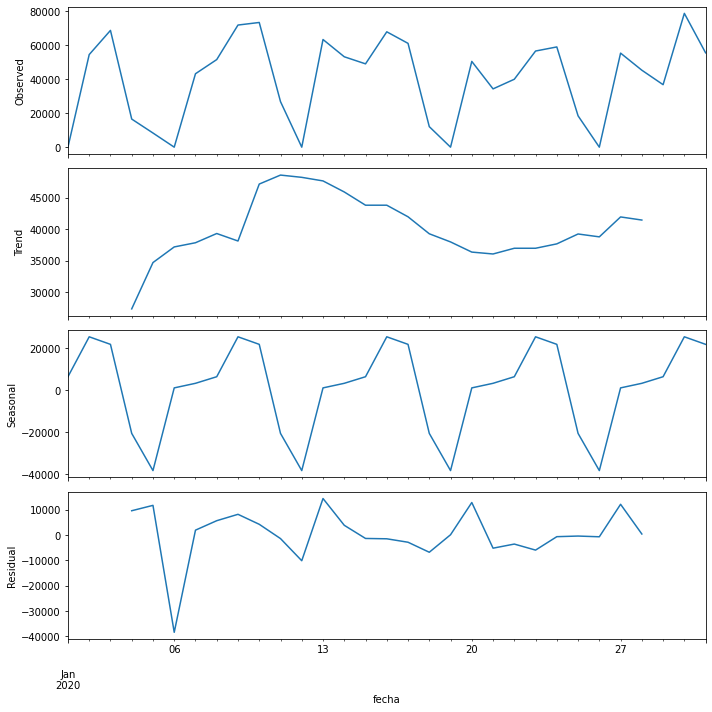

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
res = seasonal_decompose(df_2020_Enero['udsVenta'],model='additive', freq=7)
res.plot()
plt.show()

##### Estudio de ventas semanales


Se estudia si existe un comportamiento entre las diferentes semanas. Se comprueba que a nivel semanal no se produce una gran diferenia entre semanas que no se haya indicado anteriormente.


In [ ]:
Semanas =Total_Ventas_año.resample('W').mean()

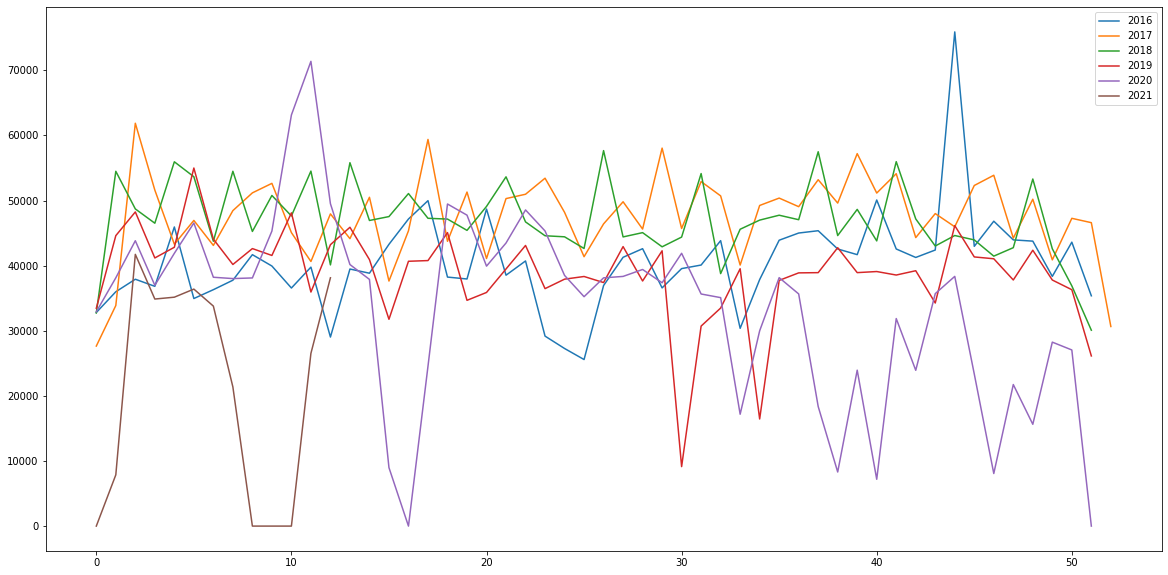

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(Semanas['2016'].values, label='2016')
plt.plot(Semanas['2017'].values, label='2017')
plt.plot(Semanas['2018'].values, label='2018')
plt.plot(Semanas['2019'].values, label='2019')
plt.plot(Semanas['2020'].values, label='2020')
plt.plot(Semanas['2021'].values, label='2021')
plt.legend()

In [ ]:
Semanas_1 = Semanas.loc[(Semanas.index >='2017-01-01') & (Semanas.index <='2019-12-31')]

Se descompone la señal en periodos semanales observando la estacionalidad constante y la tendencia a la baja estableciendo su minimo en Agosto 2019.

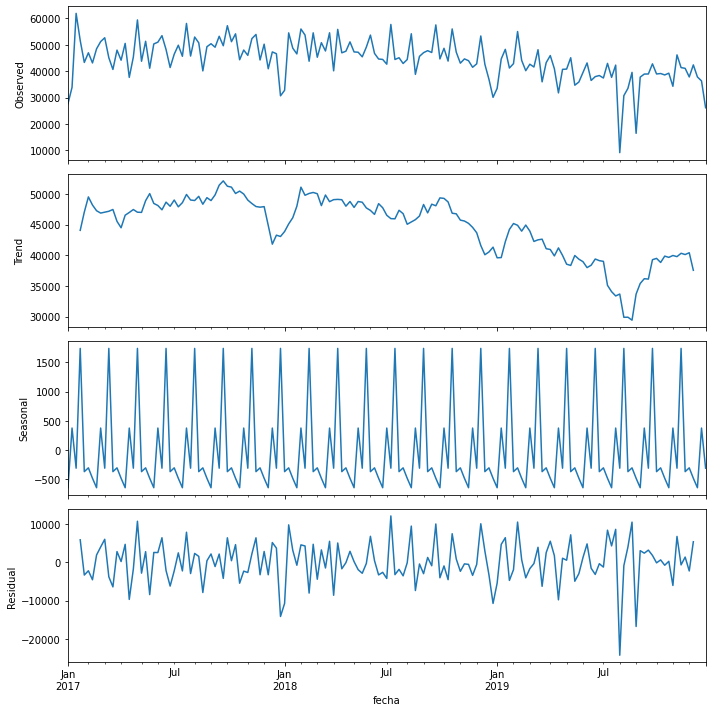

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
res = seasonal_decompose(Semanas_1['udsVenta'],model='additive', freq=7)
res.plot()
plt.show()

In [ ]:
# semana del año, dia del año, dia de la semana

In [ ]:
Total_Ventas_año['fecha']=Total_Ventas_año.index

In [ ]:
Total_Ventas_año['day_of_week'] = Total_Ventas_año['fecha'].dt.dayofweek


In [ ]:
Total_Ventas_año['y'] = Total_Ventas_año['fecha'].dt.year


In [ ]:
wp=Total_Ventas_año.loc[(Total_Ventas_año.index >='2020-01-01') & (Total_Ventas_año.index <='2020-12-31')].groupby('day_of_week').sum('udsVenta')

Se oberva que los fin de semana la demanda cae y se produce máximos en jueves y viernes

In [ ]:
wp["day"]=wp.index

<Figure size 1440x720 with 0 Axes>

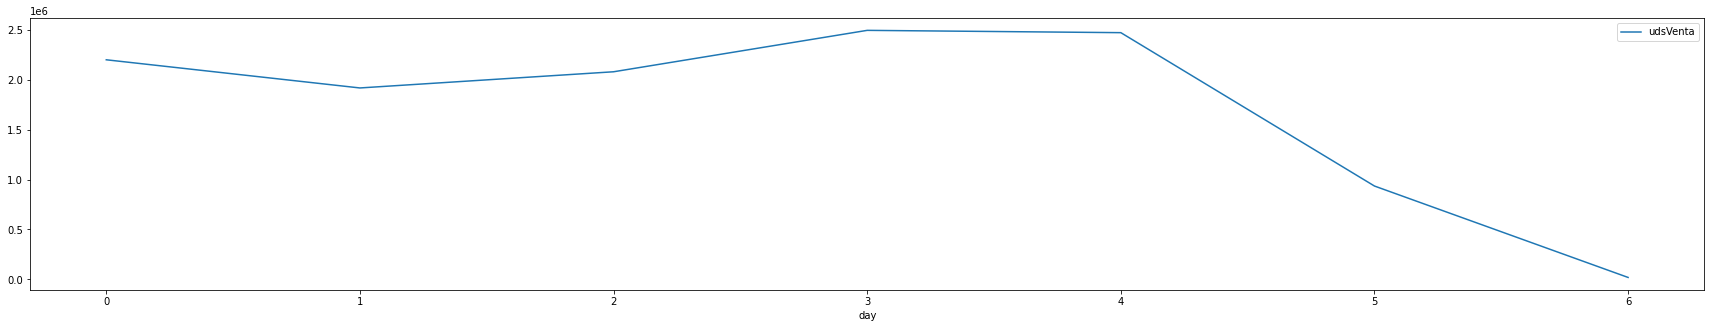

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
wp.plot(x='day', y='udsVenta', figsize=(30, 5))
plt.show()

In [ ]:
wp2=Total_Ventas_año.groupby(['y','day_of_week']).sum('udsVenta')

##### Comportamiento de la demanda en día de la semana

Despues de analizar en detalle la descomposición de la serie temporal, observamos las ventas según en el día de la semana y observamos este patrón. Implica que habrá que incluir variables estacionarías en el modelo

<Figure size 1440x720 with 0 Axes>

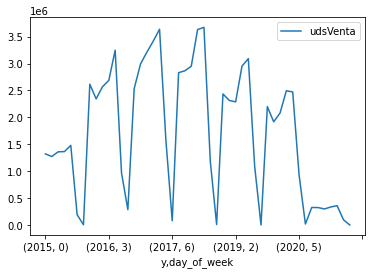

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))

wp2.plot()
plt.show()

##### Comportamiento semana del año

Solo se detecta un comportamiento diferente a principio y fin de año coincididiendo con fechas correspondientes a la semana de Navidad. La variable número de la semana no se incluirá en el modelo

In [ ]:
Total_Ventas_año['w'] = Total_Ventas_año['fecha'].dt.week


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [ ]:
wp3=Total_Ventas_año[['w','udsVenta']].groupby('w').mean('udsVenta')

<Figure size 1440x720 with 0 Axes>

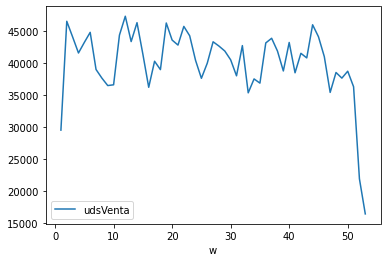

In [ ]:
plt.figure(figsize=(20,10))

wp3.plot()
plt.show()

##### Comportamiento día del mes

Se estudia el comportamiento del mes para ver si tiene un impacto en las ventas considerable. Se comprueba que es cierto, como se observa en el gráfico inferior, dado que se compra más al principio del mes que al final. Esta variable se categorizará para usarla en el modelo

In [ ]:
Total_Ventas2['fecha']=Total_Ventas2.index

Total_Ventas2["d"]= Total_Ventas2['fecha'].dt.day


In [ ]:
wp5=Total_Ventas2[['d','udsVenta']].groupby('d').mean('udsVenta')

<Figure size 1440x720 with 0 Axes>

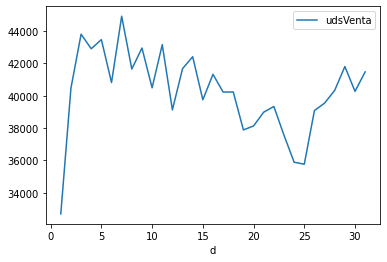

In [ ]:
plt.figure(figsize=(20,10))

wp5.plot()
plt.show()

##### Boxplot para visualizar la demanda según diferentes medidas temporales

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


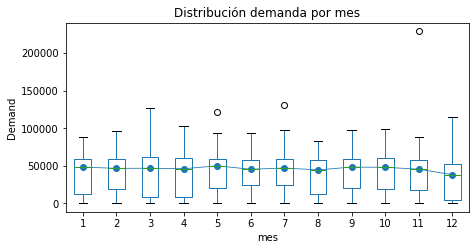

In [ ]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
Total_Ventas_año['mes'] = Total_Ventas_año.index.month
Total_Ventas_año.boxplot(column='udsVenta', by='mes', ax=ax,)
Total_Ventas_año.groupby('mes')['udsVenta'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('udsVenta')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


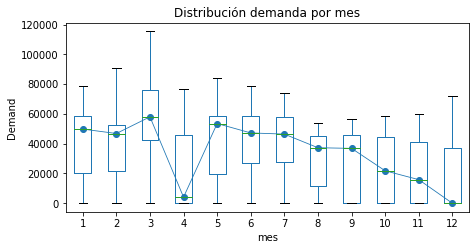

In [ ]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df_2020['mes'] = df_2020.index.month
df_2020.boxplot(column='udsVenta', by='mes', ax=ax,)
df_2020.groupby('mes')['udsVenta'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('udsVenta')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


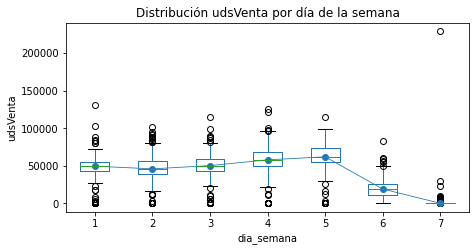

In [ ]:


# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
Total_Ventas_año['dia_semana'] = Total_Ventas_año.day_of_week + 1
Total_Ventas_año.boxplot(column='udsVenta', by='dia_semana', ax=ax)
Total_Ventas_año.groupby('dia_semana')['udsVenta'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('udsVenta')
ax.set_title('Distribución udsVenta por día de la semana')
fig.suptitle('');



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


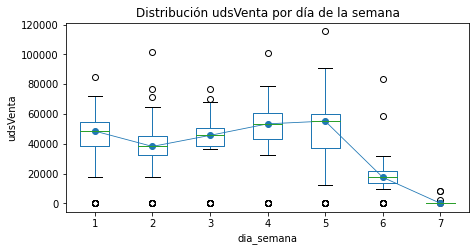

In [ ]:


# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df_2020['dia_semana'] = df_2020.index.dayofweek +1
df_2020.boxplot(column='udsVenta', by='dia_semana', ax=ax)
df_2020.groupby('dia_semana')['udsVenta'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('udsVenta')
ax.set_title('Distribución udsVenta por día de la semana')
fig.suptitle('');



#### Estudio de AutoCorrelación y Estadísticos

##### Estudio ventas totales

La autocorrelación es un tipo de dependencia de la serie temporal. En concreto, la autocorrelación se produce cuando una serie temporal está relacionada linealmente con una versión retardada de sí misma. Se comprueba esta si existe algún  patrón oculto en los datos que se haya escapado en el análisis anterior.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


Se estudia la correlación parcial

<Figure size 1440x720 with 0 Axes>

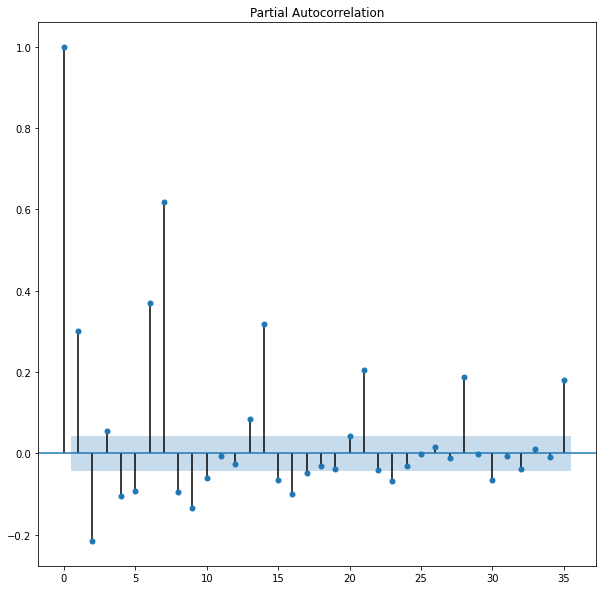

In [ ]:
plt.figure(figsize=(20,10))

plot_pacf(Total_Ventas_año,lags=35)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))

plot_acf(Total_Ventas_año,lags=35)
plt.show()

  Las líneas  en  el  gráfico  representan  la  autocorrelación  entre  la  serie  de tiempo  y  una  versión  retrasada  de  sí  misma.  La  primera  línea  indica  la autocorrelación  con  retraso  de  1  período  de  tiempo,  la  segunda  línea representa la autocorrelación para hace dos períodos y así sucesivamente. La  primera  línea  es  uno  porque  la correlación  entre  un  valor  y  sí  mismo siempre será uno.
El área azul alrededor del eje x representa la significación de los valores de autocorrelación. Es decir, mide si son significativamente distintos de cero, lo que sugiere la existencia de autocorrelación para ese retraso específico.
 Si los coeficientes son significativos, es un indicador de la dependencia del tiempo en los datos. 

En este caso para lags de más de 30 días se observa que existe cierta correlación con lags semanales. Viendo que cada 7 días tiene relación con el periodo 0 del gráfico

La función ACF se utiliza para investigar cuántos retrasos es necesario en el  modelo  de  medias  móviles. En este caso se observa conclusiones parecidas que con la función de correlación parcial

<Figure size 1440x720 with 0 Axes>

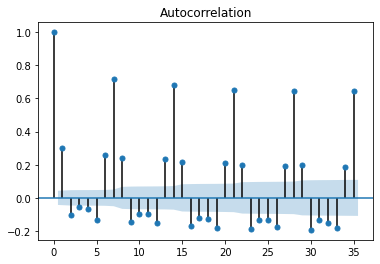

In [ ]:
plt.figure(figsize=(20,10))

plot_acf(Total_Ventas_año[["udsVenta"]],lags=35)
plt.show()

Las funciones de autocorrelación simple y parcial constituyen uno de los instrumentos clave para ajustar el modelo que genera una serie temporal. Así pues, un proceso es ergódico cuando conforme k se hace más grande, a autocorrelación se hace más pequeña. Es decir, que la dependencia entre variables tiene menos importancia pasado más tiempo.

##### Estudio año 2019

Se estudia el intervalo anual correspondiente a 2019 a ver si se observa las mismas conclusiones. 

<Figure size 1440x720 with 0 Axes>

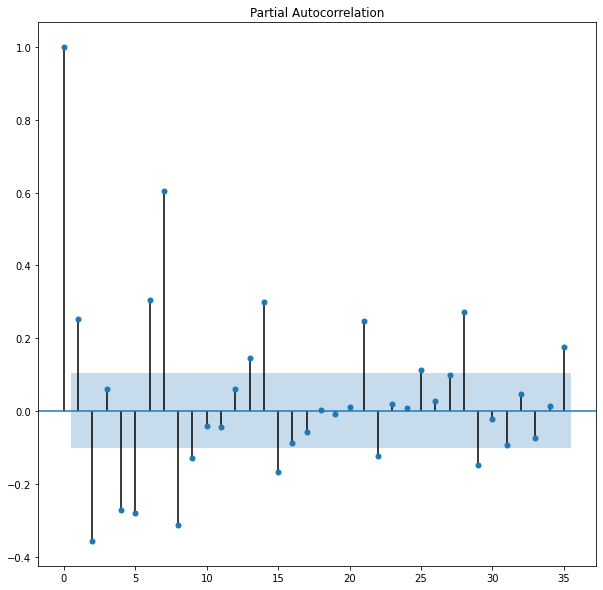

In [ ]:
plt.figure(figsize=(20,10))
plot_pacf(df_2019,lags=35)
plt.show()

Rechazar la hipótesis nula significa que el proceso no tiene raíz unitaria y, a su vez, que la serie temporal es estacionaria o no tiene una estructura dependiente del tiempo.

##### El exponente de Hurst 

La idea es utilizar este exponente para averiguar cuál es la dinámica de las ventas  y así ver si la serie tiene un comportamiento tendencial, de reversión a la media o simplemente se mueve de forma aleatoria.

In [ ]:
!pip install hurst

In [ ]:
from hurst import compute_Hc, random_walk

In [ ]:
H, c, val = compute_Hc(Total_Ventas_año["udsVenta"])

In [ ]:
print("Hurst exponent = {:.4f}".format(H))

Hurst exponent = 0.2080


Hurst < 0.5 ⇒ La serie tiene una dinámica de reversión a la media. En este caso tiene sentido porque todas las ventas a de hoy son peores que los del presente debido a esta situación un decrecimiento entre las ventas que problablente siga así si no se cambia la situación actual

### Creación Categorías (Clustering) de productos

Dado el número de productos que existen en venta, de cara a la predección de la demanda tiene sentido buscar la relacion que existen entre productos en cuanto a número de ventas para posteriormente agrupar y realizar la predección de la demanda por categoría en vez de por producto. 

Para ello se busca la relación existente entre la fecha y la compra de los productos para ver que productos se venden los mismos días y cuales no.

In [ ]:
## Correlacion entre productos

In [29]:
cluster=ventas

In [30]:
final_df=cluster.pivot(index="fecha", columns="producto",values="udsVenta")

In [31]:
corr=final_df.corr()

Se genera la matriz de correlaciónes para esteblecer de una manera visual los productos

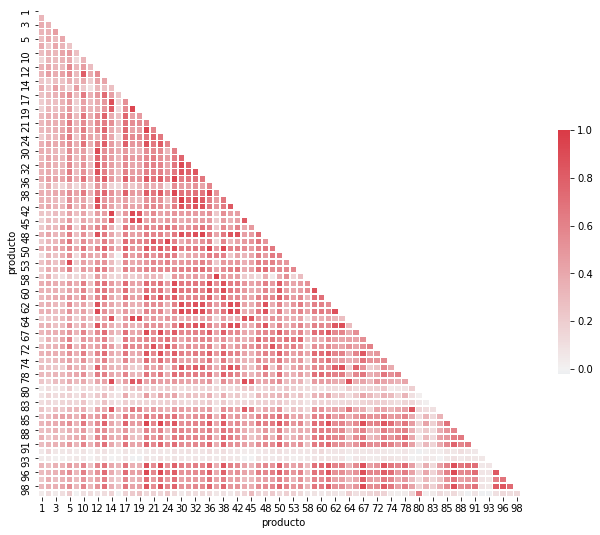

In [32]:
%matplotlib inline

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=.0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Se observa que existen una cierta relación entre varios productos, para tener más información se genera la función de inferior donde se observa la correlación entre productos donde la correlación es mayor del 70%

In [ ]:
for var in corr.columns: 
    print('Correlaciones superiores al 70% del campo ', var)
    print('')
    print(corr.loc[(corr[var] > 0.7) & (corr.index != var), var]) 
    print('')
    print('#############################################################')

Correlaciones superiores al 70% del campo  1

Series([], Name: 1, dtype: float64)

#############################################################
Correlaciones superiores al 70% del campo  2

Series([], Name: 2, dtype: float64)

#############################################################
Correlaciones superiores al 70% del campo  3

Series([], Name: 3, dtype: float64)

#############################################################
Correlaciones superiores al 70% del campo  4

Series([], Name: 4, dtype: float64)

#############################################################
Correlaciones superiores al 70% del campo  5

producto
53    0.893146
Name: 5, dtype: float64

#############################################################
Correlaciones superiores al 70% del campo  9

Series([], Name: 9, dtype: float64)

#############################################################
Correlaciones superiores al 70% del campo  10

producto
13    0.803493
Name: 10, dtype: float64

#####################

Por último, se crea un dendograma mediante la clusterización de jerarquía donde se organizan los datos en categorías estableciendo el detalle. En esta representación se aprecia claramente la relaciones entre los productos

In [33]:


dissimilarity = 1 - np.abs(corr)
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels = fcluster(hierarchy, 0.5, criterion='distance')

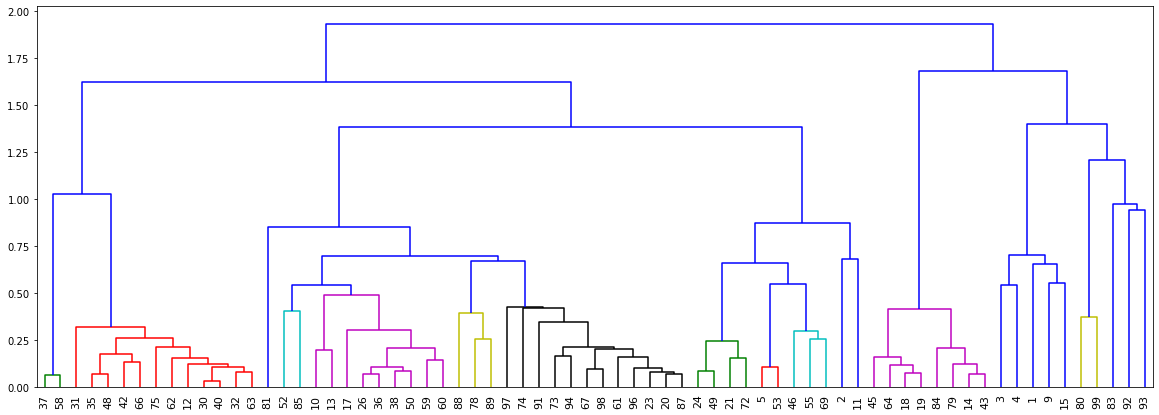

In [34]:
plt.figure(figsize=(20, 7))
dendrogram(hierarchy,color_threshold=0.5,leaf_font_size=11,labels=np.unique(ventas["producto"]))
plt.show()

In [ ]:
labels

array([18, 11, 14, 15,  9, 16,  4, 12,  2,  4, 13, 17,  4, 13, 13,  6,  8,
        6,  8,  4,  2,  2,  2,  2,  4,  1,  4,  2,  2, 13, 13, 10,  2,  8,
        4,  3,  9, 10,  1,  4,  4,  6,  2,  2, 13,  2,  6, 10,  8,  6,  6,
        2,  5, 13, 19,  7, 22, 13,  3,  6,  5,  5,  6, 20, 21,  6,  6,  6,
        6, 19], dtype=int32)

In [ ]:
np.unique(ventas["producto"])

array([ 1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21,
       23, 24, 26, 30, 31, 32, 35, 36, 37, 38, 40, 42, 43, 45, 46, 48, 49,
       50, 52, 53, 55, 58, 59, 60, 61, 62, 63, 64, 66, 67, 69, 72, 73, 74,
       75, 78, 79, 80, 81, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 96, 97,
       98, 99])

In [ ]:
categorias=pd.DataFrame(np.unique(ventas["producto"]),columns=["producto"])

In [ ]:
categorias["categorias"]=labels

In [ ]:
categorias.head()

producto  categorias
0         1          18
1         2          11
2         3          14
3         4          15
4         5           9

 # 3.4. Feature Engineering - Unión de ficheros

Se cruza el fichero de promociones con le fichero de ventas.

* En caso que no exista precio para una determinada fecha se coge el último precio conocido y se sustituye por el nulo. En caso de no encontrar ningun precio del producto de esta manera, se selecciona en primer precio cercano conocido.

* Para los productos 80,92,93,99 que no tienen precio en ningun periodo se inputa como la media de los precios 

In [ ]:
promos=Cruce_1.rename(columns = {  'Producto': 'producto'}, inplace = False)

In [ ]:
Cruce_1[["fecha","Producto"]].duplicated().sum()

0

In [ ]:
Cruce_df=pd.merge(ventas, promos, on=['producto','fecha'], how='left',left_index=False, right_index=False)

In [ ]:
Cruce_df.isna().sum()

producto                0
fecha                   0
udsVenta                0
promocion          119720
preciotarifa       119720
preciopromocion    119720
dtype: int64

In [ ]:
Cruce_df[["fecha","producto"]].duplicated().sum()

0

In [ ]:
Cruce_df["promocion"].fillna(0,inplace=True)

In [ ]:
Cruce_df['last_price'] = Cruce_df[['producto','fecha','preciotarifa']].sort_values(by=['producto','fecha']).groupby(['producto'], as_index=False).fillna(method = 'ffill')['preciotarifa']

In [ ]:
Cruce_df.isna().sum()

producto                0
fecha                   0
udsVenta                0
promocion               0
preciotarifa       119720
preciopromocion    119720
last_price          24319
dtype: int64

In [ ]:
Cruce_df['preciotarifa'] = Cruce_df['last_price']
Cruce_df = Cruce_df.drop(['last_price'], axis = 1)

In [ ]:
Cruce_df['first_price'] = Cruce_df[['producto','fecha','preciotarifa']].sort_values(by=['producto','fecha']).groupby(['producto'], as_index=False).fillna(method = 'bfill')['preciotarifa']

In [ ]:
Cruce_df.loc[Cruce_df["preciotarifa"].isna(),"preciotarifa"]=Cruce_df["first_price"]
Cruce_df = Cruce_df.drop(['first_price'], axis = 1)

In [ ]:
Cruce_df[["producto"]].loc[Cruce_df["preciotarifa"].isna()].drop_duplicates()

producto
108436        80
126094        92
127703        93
137728        99

## 3.4.1 Generación de la variable precio

Se genera la variable precio a partir de las columnas preciotarifa y preciopromoción. En caso que exista una promoción se usa la variable preciopromoción y si no existe una promoción se usa el preciotarifa

In [ ]:
Cruce_df["precio"]=None
Cruce_df.loc[Cruce_df["promocion"]==0,'precio']=Cruce_df["preciotarifa"]
Cruce_df.loc[Cruce_df["promocion"]==1,'precio']=Cruce_df["preciopromocion"]

In [ ]:
Cruce_df=Cruce_df.drop(["preciotarifa","preciopromocion"],axis=1)

In [ ]:
Cruce_df["producto"]=Cruce_df["producto"].astype("str")

In [ ]:
Cruce_df["precio"]=Cruce_df["precio"].astype(float).fillna(0.0)

In [ ]:
precios_producto=Cruce_df.groupby(['producto'])["precio"].mean("precio")

In [ ]:
precios_producto.mean()

3.614085775836306

In [ ]:
Cruce_df[["producto"]].loc[Cruce_df["precio"]==0].drop_duplicates()

producto
108436       80
126094       92
127703       93
137728       99

In [ ]:
Cruce_df.replace(0, 3.6140, inplace=True)


## 3.4.2 Generación día de la semana y semana del mes

Se divide el mes en 4 semanas de cara a realizar el modelo, en el analisis estádistico se observa las diferencias entre la primera semana del mes y la último, se divide el mes en cuatro estados que serán útiles para el modelo

In [ ]:

def weekinmonth(dates):
    """Te da el la semana del mes".
    """
    firstday_in_month = dates - pd.to_timedelta(dates.dt.day - 1, unit='d')
    return (dates.dt.day-1 + firstday_in_month.dt.weekday) // 7 + 1

In [ ]:
Cruce_df['day_of_week'] = Cruce_df['fecha'].dt.dayofweek
Cruce_df['w'] = weekinmonth(Cruce_df['fecha'])



In [ ]:
Cruce_df.loc[Cruce_df["w"]>4,'w']

Series([], Name: w, dtype: object)

In [ ]:
Cruce_df.loc[Cruce_df["w"]>4,'w']=4

## 3.4.3 Variable promoción. 
###Comparación ventas promos vs no promos

Se comprueba si existe diferencía entre los días de  ventas en promoción frente a los días de ventas de no promoción

Se realiza la comprobación por producto y por día de la semana. En ambos gráficos se observa que la demanda es mayor en días de promoción frente a la demanda en días sin promoción

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


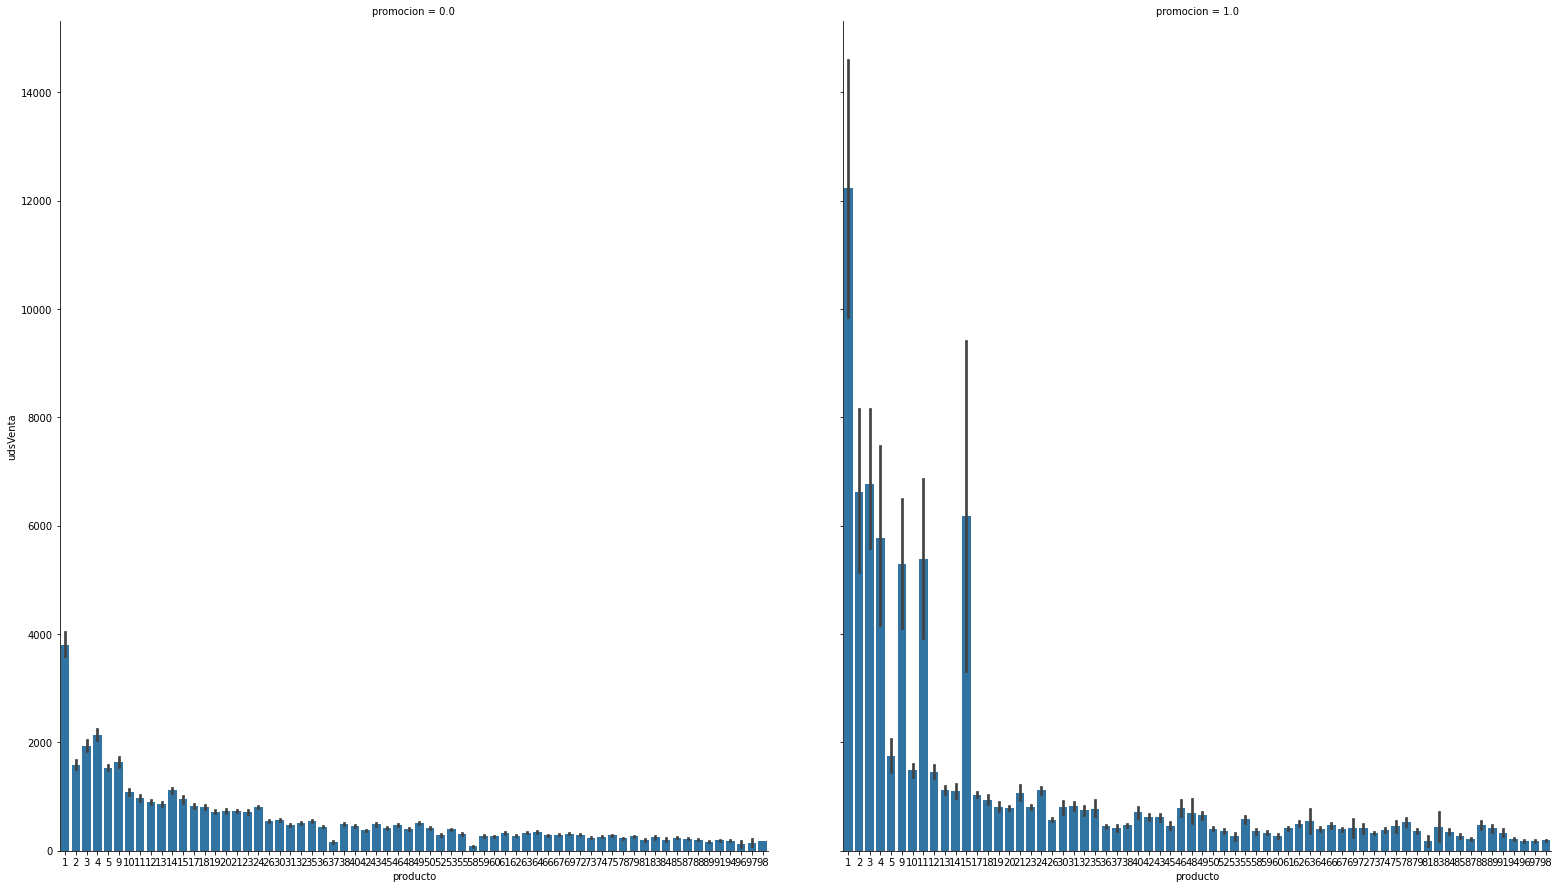

In [ ]:
g = sns.FacetGrid(Cruce_df, col="promocion", height=4, aspect=.8)
g.map(sns.barplot, "producto", "udsVenta")
g.fig.set_size_inches(25,15)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


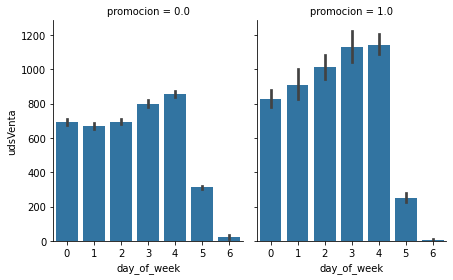

In [ ]:
g = sns.FacetGrid(Cruce_df, col="promocion", height=4, aspect=.8)
g.map(sns.barplot, "day_of_week", "udsVenta");

## 3.4.4 Creación de la variable festivo

Se generá la variable festivo, se comprueba si tiene sentido de cara el modelo

Se revisa y se analiza que los días en los que hay un festivo la empresa tiene un volumen de demanda menor que en días no festivos

In [ ]:
import holidays

In [ ]:
ESP=[]
for i in range (2015,2022,1):
  for date in holidays.ESP(prov="AR", years=i).items():
    ESP.append(date[0])

In [ ]:
Cruce_df.loc[Cruce_df["fecha"].isin(ESP),"festivo"]=1


In [ ]:
Cruce_df["festivo"].fillna(0,inplace=True)

In [ ]:
x=Cruce_df[['day_of_week','udsVenta','festivo']].groupby(['festivo','day_of_week'],as_index=False).mean('udsVenta')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


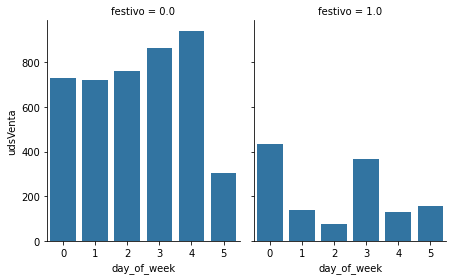

In [ ]:
g = sns.FacetGrid(x, col="festivo", height=4, aspect=.8)
g.map(sns.barplot, "day_of_week", "udsVenta");

## 3.4.5 Estudio de inclusión de nuevas variables temporales


Se añaden las siguientes características considerando las promociones y en el día anterior y posterior o semana anterior y posterior:

- `precampaña`: 1 si es día previo a una promoción,
- `postcampaña`: 1 si es  día posterior a una promoción,
- `pre_sem_campaña`: 1 si es  en día de la semana  previo a una promoción, es decir si en 7 días hay una promoción.
- `post_sem_campaña`: 1 si es en el semana posterior a una campaña,

Se generan estas variables siguiendo criterio de negocio, esperando observar si tiene algún efecto que los demandantes esperen a comprar al día de la promoción o por el contrario que despues de una promoción la demanda caiga

In [ ]:
### Generación de variables

In [ ]:
DiaPostcampaña=[]
Producto_Post=[]
for i in range(137630):

  if((Cruce_df.iloc[i+1,3]==0)&(Cruce_df.iloc[i,3]==1)):
    DiaPostcampaña.append(Cruce_df.iloc[i+1,1])
    Producto_Post.append(Cruce_df.iloc[i+1,0])

In [ ]:
df_postcampaña = pd.DataFrame(Producto_Post, columns=['producto'])
df_postcampaña.loc[:,'fecha'] = DiaPostcampaña

In [ ]:
DiaPrecampaña=[]
Producto_Prep=[]
for i in range(1,137630):

  if((Cruce_df.iloc[i-1,3]==0)&(Cruce_df.iloc[i,3]==1)):
    DiaPrecampaña.append(Cruce_df.iloc[i-1,1])
    Producto_Prep.append(Cruce_df.iloc[i-1,0])


In [ ]:
df_precampaña = pd.DataFrame(Producto_Prep, columns=['producto'])
df_precampaña.loc[:,'fecha'] = DiaPrecampaña

In [ ]:
df_precampaña.loc[:,'fecha'] = DiaPrecampaña

In [ ]:
SemPrecampaña=[]
Producto_Sem_Prep=[]
for i in range(1,137630):

  if((Cruce_df.iloc[i-7,3]==0)&(Cruce_df.iloc[i,3]==1)):
    SemPrecampaña.append(Cruce_df.iloc[i-7,1])
    Producto_Sem_Prep.append(Cruce_df.iloc[i-7,0])

In [ ]:
sem_precampaña = pd.DataFrame(Producto_Sem_Prep, columns=['producto'])
sem_precampaña.loc[:,'fecha'] = SemPrecampaña

In [ ]:
SemPostcampaña=[]
Producto_Sem_Post=[]
for i in range(1,137630):

  if((Cruce_df.iloc[i+7,3]==0)&(Cruce_df.iloc[i,3]==1)):
    SemPostcampaña.append(Cruce_df.iloc[i+7,1])
    Producto_Sem_Post.append(Cruce_df.iloc[i+7,0])

In [ ]:
sem_postcampaña = pd.DataFrame(Producto_Sem_Post, columns=['producto'])
sem_postcampaña.loc[:,'fecha'] = SemPostcampaña

In [ ]:
df_postcampaña["post_promocion"]=1

In [ ]:
df_precampaña["pre_promocion"]=1

In [ ]:
sem_precampaña["pre_semana"]=1

In [ ]:
sem_postcampaña["post_semana"]=1

In [ ]:
Cruce_df1=pd.merge(Cruce_df, df_precampaña, on=['producto','fecha'], how='left',left_index=False, right_index=False)

In [ ]:
Cruce_df1["pre_promocion"].fillna(0,inplace=True)

In [ ]:
Cruce_df2=pd.merge(Cruce_df1, df_postcampaña, on=['producto','fecha'], how='left',left_index=False, right_index=False)

In [ ]:
Cruce_df2["post_promocion"].fillna(0,inplace=True)

In [ ]:
Cruce_df3=pd.merge(Cruce_df2, sem_precampaña, on=['producto','fecha'], how='left',left_index=False, right_index=False)

In [ ]:
Cruce_df3["pre_semana"].fillna(0,inplace=True)

In [ ]:
Cruce_df4=pd.merge(Cruce_df3, sem_postcampaña, on=['producto','fecha'], how='left',left_index=False, right_index=False)

In [ ]:
Cruce_df4["post_semana"].fillna(0,inplace=True)

In [ ]:
Estudio_Variables=Cruce_df4.loc[Cruce_df4["promocion"]==0]

#### Estudo de la variable pre_promoción

Se estudía la variable pre_promoción, a priori el día previo a una promoción podría suponer una reducción de ventas. En este caso como existe bastante relación entre productos es posible que cuando un producto este en promoción y tenga relación con otro en no promoción se produzca la compra de los dos.

 Por tanto, la variable pre_promoción se incluye en el modelo como variable temporal

In [ ]:
x1=Estudio_Variables[['day_of_week','udsVenta','pre_promocion']].groupby(['pre_promocion','day_of_week'],as_index=False).mean('udsVenta')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


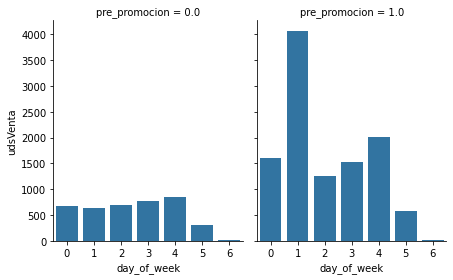

In [ ]:
g = sns.FacetGrid(x1, col="pre_promocion", height=4, aspect=.8)
g.map(sns.barplot, "day_of_week", "udsVenta");

#### Estudo de la variable post_promoción

Este caso la variable post_promoción como se observa en el gráfico inferior no ofrece resultados concluyentes y no se incluye como variable en el modelo

In [ ]:
x2=Estudio_Variables[['day_of_week','udsVenta','post_promocion']].groupby(['post_promocion','day_of_week'],as_index=False).mean('udsVenta')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


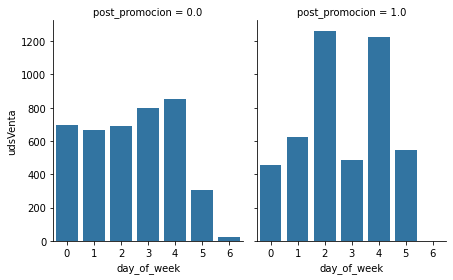

In [ ]:
g = sns.FacetGrid(x2, col="post_promocion", height=4, aspect=.8)
g.map(sns.barplot, "day_of_week", "udsVenta");

#### Estudio pre_semana y post_semana

Una vez generadas las dos variables se analiza sus distribuciones y se observa que tienen una distribución similar a datos que no contengan este booleano. Por tanto, se dedice no incluir estas variables en el modelo

In [ ]:
x3=Estudio_Variables[['day_of_week','udsVenta','pre_semana']].groupby(['pre_semana','day_of_week'],as_index=False).mean('udsVenta')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


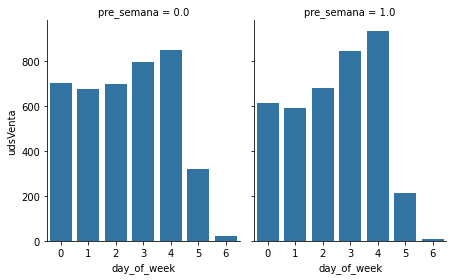

In [ ]:
g = sns.FacetGrid(x3, col="pre_semana", height=4, aspect=.8)
g.map(sns.barplot, "day_of_week", "udsVenta");

In [ ]:
x4=Estudio_Variables[['day_of_week','udsVenta','post_semana']].groupby(['post_semana','day_of_week'],as_index=False).mean('udsVenta')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


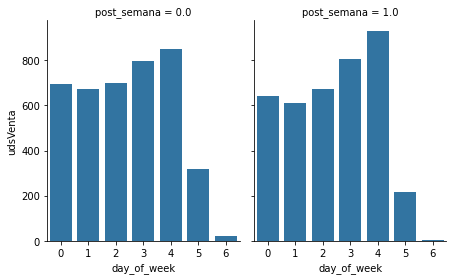

In [ ]:
g = sns.FacetGrid(x4, col="post_semana", height=4, aspect=.8)
g.map(sns.barplot, "day_of_week", "udsVenta");

## 3.4.6 Variables dedicadas a las ventas

*Estas variables se generan para conjunto de datos actual. En caso de filtrar las variabres estas tendrán que ser generadas de nuevo. Esto se encuentra en el Notebook 03*

#### Generación de medidas moviles

Se calcula la medidas móvil para homogenizar las tendencias durante un periodo de tiempo además ayuda al modelo a entender la tendencia de la demanda en un periodo en particular

Se calculan por producto:
* *Media_W4* La media de los últimos 4 días de la semana correspondientes. Por ejemplo, la media de los últimos 4 Lunes.
* *Media_W2* Meda de los últimos 2 días de la semana. Por ejemplo, la media de ventas de los últimos 2 Lunes.

* *Mediana_7D* Mediana de los últimos 7 días.
* *MAX_2M* Maxima ventas de los últimos 2 meses (56 dias)
* *pcte_7D* Porcentaje de variación de ventas en los últimos 7 días. *Esta variable al haber valores a 0s inputan muchos nulos y posteriormente se elimina*

In [ ]:
Productos=np.unique(Cruce_df4["producto"])
dias=np.unique(Cruce_df4["day_of_week"])

In [ ]:
for i in  Productos:
  for j in  dias:
   Cruce_df4.loc[(Cruce_df4["producto"]==i)&(Cruce_df4["day_of_week"]== j),'Media_W4']=Cruce_df4.loc[(Cruce_df4["producto"]==i)&(Cruce_df4["day_of_week"]== j),"udsVenta"].rolling(window=4).mean()

In [ ]:
for i in  Productos:
  for j in  dias:
       Cruce_df4.loc[(Cruce_df4["producto"]==i)&(Cruce_df4["day_of_week"]== j),'Media_W2']=Cruce_df4.loc[(Cruce_df4["producto"]==i)&(Cruce_df4["day_of_week"]== j),"udsVenta"].rolling(window=2).mean()

In [ ]:
for i in  Productos:
  for j in  dias:
       Cruce_df4.loc[(Cruce_df4["producto"]==i),'Mediana_7D']=Cruce_df4.loc[(Cruce_df4["producto"]==i),"udsVenta"].rolling(window=7).median()

In [ ]:
for i in  Productos:
  for j in  dias:
       Cruce_df4.loc[(Cruce_df4["producto"]==i),'MAX_2M']=Cruce_df4.loc[(Cruce_df4["producto"]==i),"udsVenta"].rolling(window=56).max()

In [ ]:
Cruce_df4.index=Cruce_df4["fecha"]

In [ ]:
for i in  Productos:
  for j in  dias:
       Cruce_df4.loc[(Cruce_df4["producto"]==i),'pcte_7D']=Cruce_df4.loc[(Cruce_df4["producto"]==i),"udsVenta"].pct_change(freq='7D')

In [ ]:
Cruce_df4 = Cruce_df4.reset_index(drop = True)

### Índice de fuerza relativa (RSI)

El Índice de Fuerza Relativa (RSI) calcula una relación entre los recientes movimientos de ventas al alza y el movimiento de ventas  absoluto. Esto sirve para medir tanto la velocidad en los cambios en la demanda como también los posibles niveles de sobre demanda o al contrario.  

 En primer lugar, se obtiene la ganancia o pérdida promedio, que mide la suba o baja promedio de ventas  durante período determinado. En este caso 2 semanas.

 Con estas dos variables se calcula la fuerza promedia que es la división de estas variables y posteriormente se normaliza para  RSI se calcula como RSI = 100  100 / (1+RS) que fluctua de 0 100. Un valor de RSI cero significa que los precios se movieron a la baja en los 14 periodos y por tanto seguirá llendo a la baja. 

El RSI se interpreta como un indicador de sobrecompra/sobreventa cuando el valor es superior a 70/inferior a 30. En este caso se interpretará como oscilación hacia el aumento de compras si es mayor de 70 y cuando el indicador sea menor que 30 la oscilación de la demanda caerá a la baja

Indicar que como la estacionalidad es semanal el indicador rondará el valor 50 debido a las caidas de demanda y las tendencias son semanales

In [ ]:
for k in  Productos:
    df= Cruce_df4.loc[(Cruce_df4["producto"]==k)][["udsVenta"]]
    df['change'] = df['udsVenta'].diff(1) # Calculate change
    # calculate gain / loss from every change
    df['gain'] = np.select([df['change']>0, df['change'].isna()], 
                          [df['change'], np.nan], 
                          default=0) 
    df['loss'] = np.select([df['change']<0, df['change'].isna()], 
                          [-df['change'], np.nan], 
                          default=0)

    # create avg_gain /  avg_loss columns with all nan
    df['avg_gain'] = np.nan 
    df['avg_loss'] = np.nan

    n = 14 # what is the window

    # keep first occurrence of rolling mean
    df['avg_gain'][n] = df['gain'].rolling(window=n).mean().dropna().iloc[0] 
    df['avg_loss'][n] = df['loss'].rolling(window=n).mean().dropna().iloc[0]
    # Alternatively
    df['avg_gain'][n] = df.loc[:n, 'gain'].mean()
    df['avg_loss'][n] = df.loc[:n, 'loss'].mean()

    # This is not a pandas way, looping through the pandas series, but it does what you need
    for i in range(n+1, df.shape[0]):
        df['avg_gain'].iloc[i] = (df['avg_gain'].iloc[i-1] * (n - 1) + df['gain'].iloc[i]) / n
        df['avg_loss'].iloc[i] = (df['avg_loss'].iloc[i-1] * (n - 1) + df['loss'].iloc[i]) / n

    # calculate rs and rsi
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['rsi'] = 100 - (100 / (1 + df['rs'] ))



    Cruce_df4.loc[(Cruce_df4["producto"]==k),'rsi']=df[['rsi']].to_numpy() 
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'avg_gain_14D']=df[['avg_gain']].to_numpy() 
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'avg_loss_14D']=df[['avg_loss']].to_numpy() 

### Bandas de Bollinger


Bandas de Bollinger (BB) - Las bandas de Bollinger constan de tres líneas. La banda central es una media móvil simple del precio. Las bandas superior e inferior son desviaciones estándar F (generalmente 2) por encima y por debajo de la banda media. Las bandas se ensanchan y estrechan cuando la volatilidad del precio es mayor o menor, respectivamente.

 En este caso como la desviación es muy grande se crean 2 bandas superiores. Una linea semanal y una mensual

Se ilustra el ejemplo con el producto número 1

In [ ]:
plot2= Cruce_df4.loc[(Cruce_df4["producto"]=="1")][["udsVenta","fecha"]]


In [ ]:
multiplier = 2
plot2['UpperBand_weekly'] = plot2['udsVenta'].rolling(7).mean() + plot2['udsVenta'].rolling(7).std() * multiplier
plot2['UpperBand_monthly'] = plot2['udsVenta'].rolling(28).mean()+ plot2['udsVenta'].rolling(28).std() * multiplier

In [ ]:
plot2=plot2.loc[plot2["fecha"]>='2020-01-01']

In [ ]:
plot2.set_index("fecha",inplace=True)

Se observa que esta variable nos da el techo de la demanda por producto

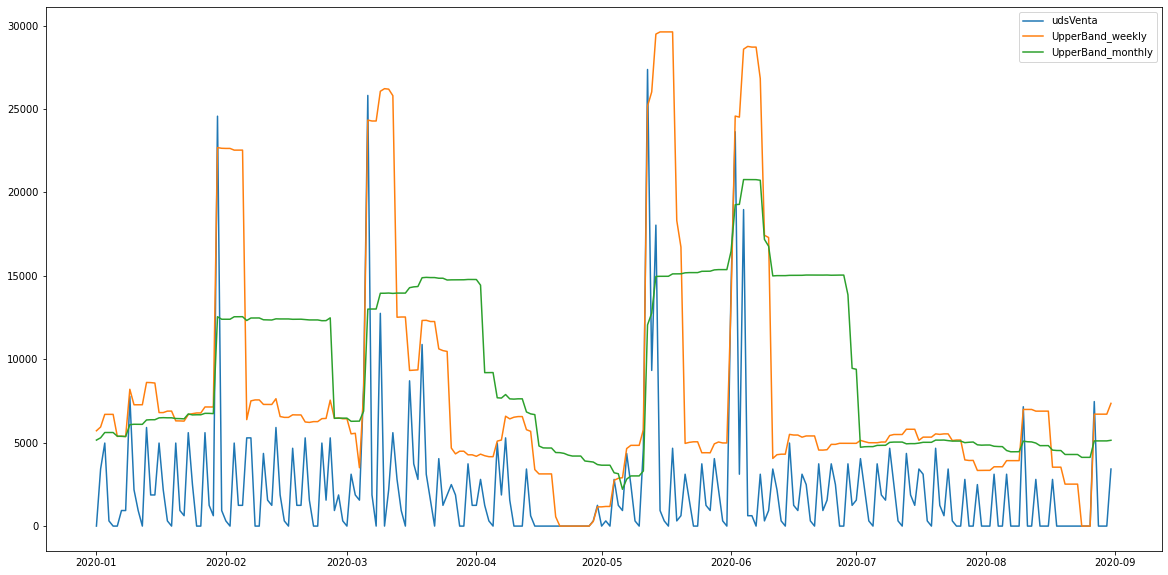

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(plot2['udsVenta'], label = "udsVenta")
plt.plot(plot2['UpperBand_weekly'], label = "UpperBand_weekly")
plt.plot(plot2['UpperBand_monthly'], label = "UpperBand_monthly")

plt.legend()

plt.show()

In [ ]:
multiplier = 2

In [ ]:
for k in  Productos:
    plot2= Cruce_df4.loc[(Cruce_df4["producto"]==k)][["udsVenta"]]
    plot2['UpperBand_weekly'] = plot2['udsVenta'].rolling(7).mean() + plot2['udsVenta'].rolling(7).std() * multiplier
    plot2['UpperBand_monthly'] = plot2['udsVenta'].rolling(28).mean()+ plot2['udsVenta'].rolling(28).std() * multiplier
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'UpperBand_weekly']=plot2[['UpperBand_weekly']].to_numpy() 
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'UpperBand_monthly']=plot2[['UpperBand_monthly']].to_numpy() 


## 3.4.7 Feature Engineering Final

In [ ]:
Cruce_df4.columns

Index(['producto', 'fecha', 'udsVenta', 'promocion', 'precio', 'day_of_week',
       'w', 'festivo', 'pre_promocion', 'post_promocion', 'pre_semana',
       'post_semana', 'Media_W4', 'Media_W2', 'Mediana_7D', 'MAX_2M',
       'pcte_7D', 'rsi', 'avg_gain_14D', 'avg_loss_14D', 'UpperBand_weekly',
       'UpperBand_monthly'],
      dtype='object')

Se seleccionan las columnas que se han ido indicando

In [ ]:
Cruce_df4=Cruce_df4[["producto","fecha","promocion","w","festivo","precio",
                     "pre_promocion",'Media_W4', 'Media_W2', 'Mediana_7D', 'MAX_2M' ,'UpperBand_weekly','UpperBand_monthly','rsi','udsVenta']]

In [ ]:
Cruce_df4['weekday'] = Cruce_df4['fecha'].dt.day_name()



Se categoriza el indicador RSI

In [ ]:
bins = [0, 29.999, 69.999, 1000]
group_names = [1,2,3]
Cruce_df4['rsi_cat'] = pd.cut(Cruce_df4['rsi'], bins, labels=group_names)


Se crean las variables one-hot-encoding con los valores que tienen las variables día de la semana, semana del mes e indicador RSI

In [ ]:
final_df = pd.get_dummies(Cruce_df4, columns=["weekday","w","rsi_cat"])

In [ ]:
final_df = final_df.drop(['rsi'], axis = 1)

In [ ]:
categorias["producto"]=categorias["producto"].astype('str')

In [ ]:
final_df1=pd.merge(final_df, categorias, on=['producto'], how='left',left_index=False, right_index=False)

In [ ]:
final_df1.head()

producto      fecha  promocion  ...  rsi_cat_2  rsi_cat_3  categorias
0        1 2015-06-29        0.0  ...          0          0          18
1        1 2015-06-30        0.0  ...          0          0          18
2        1 2015-07-01        0.0  ...          0          0          18
3        1 2015-07-02        0.0  ...          0          0          18
4        1 2015-07-03        0.0  ...          0          0          18

[5 rows x 28 columns]

##### Domingo ventas =0

Se indica desde negocio que los domingos, las ventas son 0s ya que la tienda se encuentra cerrada.

In [ ]:
final_df1.loc[final_df1["weekday_Sunday"]==1,'udsVenta']=0


### Analisis de variables final

Se realiza el analisis final mediante la matriz de correlación. Se observa que la variable MAX_2M y Mediana tienen una correlación positiva muy grande y se deciden eliminarlas de cara al modelo final

In [ ]:
corr2 = final_df1[[ 'precio',
       'Media_W4', 'Media_W2', 'Mediana_7D', 'MAX_2M', 'UpperBand_weekly',
       'UpperBand_monthly' ]].corr(method='kendall')

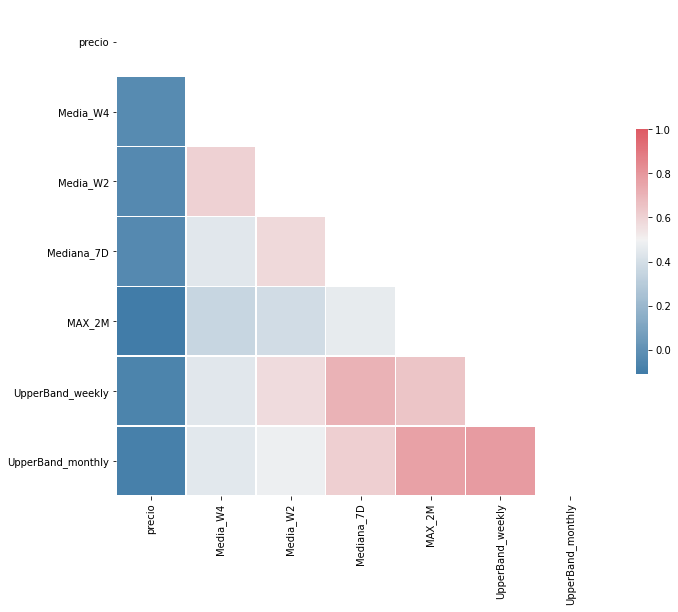

In [ ]:
%matplotlib inline

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr2, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=1, center=.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Se detecta que MAX_2M y Media_W2 estan relacionadas con UpperBand_monthly y Media_W4 respectivamente, se eliminan en los notebook de modelado

# 3.5 Cruce del  Dataframe con el fichero de previsiones.

In [ ]:
Previsiones_Filtrado

In [ ]:
prevision=pd.read_csv(ruta+"Previsiones_Filtrado.csv")


In [ ]:
prevision=prevision.rename(columns = { 'Producto': 'producto'})

In [ ]:
prevision.loc[prevision["weekday"]==6,'udsPrevisionEmpresa']=0


In [ ]:
prevision=prevision[["producto","fecha","udsPrevisionEmpresa"]]

In [ ]:
prevision["producto"]=prevision["producto"].astype("str")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Export_final=pd.merge(final_df1, prevision, on=['producto','fecha'], how='left',left_index=False, right_index=False)

In [ ]:
Export_final.to_csv("/content/gdrive/MyDrive/TFM/3/MODELAR_FINAL.csv", index = False)
